# **-----Book Rating Prediction using Data from Goodreads-----**

Python version: 3.11.5

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import os
import csv
import re
from replace_accents import replace_accents_characters
from datetime import datetime, date, time
from scipy import stats

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9980\2827420316.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## **SUMMARY**

1. Import the data and correct importation errors<br> 
2. Exploratory data analysis (pre-cleaning)<br> 
3. Data cleaning:<br>
    * Change all letters to lowercase
    * Eliminate accents (lating characters only)
    * Remove extra spaces
    * Find the real unique publishers and update (ex. "Scholastic" and "Scholastic Inc" are the same)
    * Correct dates (fix bad dates and format all)
    * Make a column for the first author (the authors column can cantain many participants)
    * Purge bad data (books where the rating is clearly not reliable, i.e. too few reviews)
4. Feature engineering<br>
    * Add a column showing how many books have been published by the author
    * Add a column showing how many books have been published by the publisher
    * Categorize the languages
    * Add a column for length of the book title
    * Add a column for number of authors/participants
    * Add a column for author's average rating
    * Add a column for publisher's average rating
    * Split the date column into quarter, month, and year columns
5. Exploratory data analysis (post-cleaning)<br> 
6. Remove outliers (not used - only for testing)<br>
7. Transformation into computer useable data<br>
    * Drop unneeded columns
    * Apply a logarithmic function to ratings counts
    * Standardizing and normalizing data
8. Model testing<br>
    * Test a polynomial regression model with several feature sets
    * Test a random forest regression model with the same feature sets
9. Importation of scraped data (book format and genres)<br>
10. Exploratory data analysis of scraped data<br> 
11. Model testing with scraped data<br>
    * Test a polynomial regression model with several feature sets (subgenres cause failure)
    * Test a random forest regression model with the same feature sets + subgenres
12. Post-modelization analysis
    * Examine which ratings (low, medium, high) have good prediction
    * Examine the residuals and the best/worst predictions

### **1) IMPORT THE DATA AND CORRECT ERRORS**

In [2]:
#Enter the repertory for all project files:
repPath = "./"

#Import the data file while saving the bad lines in a list
badLines = []
def recordBadLines(bad_line):
    badLines.append(bad_line)
    return

#Import the csv file. Record the bad lines via a function. This requires the python engine, which will apply quoting rules. All quotes must be ignored for this data.
goodreads_df = pd.read_csv(repPath + "books.csv", dtype = {'isbn': str, 'isbn13': str}, on_bad_lines = recordBadLines, engine = 'python', quoting=csv.QUOTE_NONE)

#Toggle the display of all columns
pd.set_option('display.max_columns', None)

#Fix the column header that has extra spaces:
goodreads_df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)

#Show the bad lines during importation (excluded from dataframe for the moment)
print(badLines)

[['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press'], ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press'], ['22128', 'Patriots (The Coming Collapse)', 'James Wesley', ' Rawles', '3.63', '156384155X', '9781563841552', 'eng', '342', '38', '4', '1/15/1999', 'Huntington House Publishers'], ['34889', "Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purposes And Department Of Trade Examinations.", 'Brown', ' Son & Ferguson', '0.00', '0851742718', '9780851742717', 'eng', '49', '0', '0', '5/1/1977', 'Brown Son & Ferguson Ltd.']]


In [3]:
#Fix the broken entry - they all have the author column split in two -> the same algorithm can be used for all of them:
fixedErrors = []

for entry in badLines:
    itemIndex = 0
    tempList = []
    for item in entry:
        if itemIndex == 2:
            temp = item
        elif itemIndex == 3:
            fixedString = temp + "," + item
            tempList.append(fixedString)
        else:
            tempList.append(item)
        itemIndex += 1
    fixedErrors.append(tempList)

#Save column names and their datatypes in a series object -> to be used to convert the list into a dataframe
#Note: the as_dict function does not work properly for this use case, so another method is used
ColTypeInfo = goodreads_df.dtypes
dictColTypeInfo = {}
count = 0
for i in ColTypeInfo.index:
    dictColTypeInfo[i] = ColTypeInfo.values[count].name
    count += 1
dictColTypeInfo

#Convert the list of fixed entries into a dataframe using the column names and datatypes of the main dataframe
fixedErrorsDF = pd.DataFrame(fixedErrors, columns = dictColTypeInfo.keys())
fixedErrorsDF = fixedErrorsDF.astype(dictColTypeInfo)

#Add the fixed entries to the main dataframe
goodreads_df = pd.concat([goodreads_df, fixedErrorsDF], axis = 0, ignore_index = True)
goodreads_df.tail()

bookID                                              title  \
11122   45641                        Las aventuras de Tom Sawyer   
11123   12224  Streetcar Suburbs: The Process of Growth in Bo...   
11124   16914                  The Tolkien Fan's Medieval Reader   
11125   22128                     Patriots (The Coming Collapse)   
11126   34889  Brown's Star Atlas: Showing All The Bright Sta...   

                                                 authors  average_rating  \
11122                                         Mark Twain            3.91   
11123                 Sam Bass Warner, Jr./Sam B. Warner            3.58   
11124  David E. Smith (Turgon of TheOneRing.net, one ...            3.58   
11125                               James Wesley, Rawles            3.63   
11126                              Brown, Son & Ferguson            0.00   

             isbn         isbn13 language_code  num_pages  ratings_count  \
11122  8497646983  9788497646987           spa        272            113   
11123  0674842111  9780674842113         en-US        236             61   
11124  1593600119  9781593600112           eng        400             26   
11125  156384155X  9781563841552           eng        342             38   
11126  0851742718  9780851742717           eng         49              0   

       text_reviews_count publication_date                    publisher  
11122                  12        5/28/2006                Edimat Libros  
11123                   6        4/20/2004     Harvard University Press  
11124                   4         4/6/2004            Cold Spring Press  
11125                   4        1/15/1999  Huntington House Publishers  
11126                   0         5/1/1977    Brown Son & Ferguson Ltd.

In [4]:
#Verify how many NaN are in the data set:
goodreads_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [5]:
#Check for duplicates
goodreads_df.duplicated().sum()

0

### **2) EXPLORATORY DATA ANALYSIS (PRE-CLEANING)**

**2a) Check all data**

In [6]:
#Check the datatypes and column names
goodreads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  object 
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.0+ MB


**2b) Check numeric data**

In [7]:
# Getting descriptive statistics for the numeric part of the dataset
goodreads_df.describe().transpose()

count          mean            std  min       25%  \
bookID              11127.0  21310.938887   13093.358023  1.0  10287.00   
average_rating      11127.0      3.933631       0.352445  0.0      3.77   
num_pages           11127.0    336.376921     241.127305  0.0    192.00   
ratings_count       11127.0  17936.409095  112479.441449  0.0    104.00   
text_reviews_count  11127.0    541.854498    2576.176608  0.0      9.00   

                         50%        75%        max  
bookID              20287.00  32104.500    45641.0  
average_rating          3.96      4.135        5.0  
num_pages             299.00    416.000     6576.0  
ratings_count         745.00   4993.500  4597666.0  
text_reviews_count     46.00    237.500    94265.0

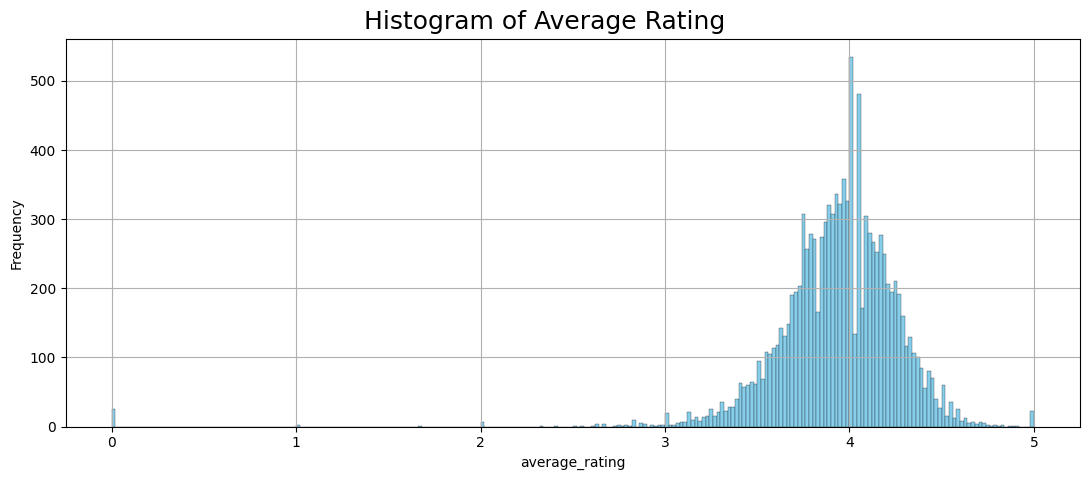

In [8]:
#Look at the distribution of the average rating
numerical_cols = ["average_rating"]

plt.figure(figsize=(11, 5))
plt.suptitle("Histogram of Average Rating", fontsize=18, y=0.95)

#Possibility to do subplots. For the moment, only one chart is made
for i, column in enumerate(numerical_cols):
    plt.subplot(1, 1, i+1)
    goodreads_df[column].hist(bins=250, color='skyblue', edgecolor='black', linewidth=0.2)
    #plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

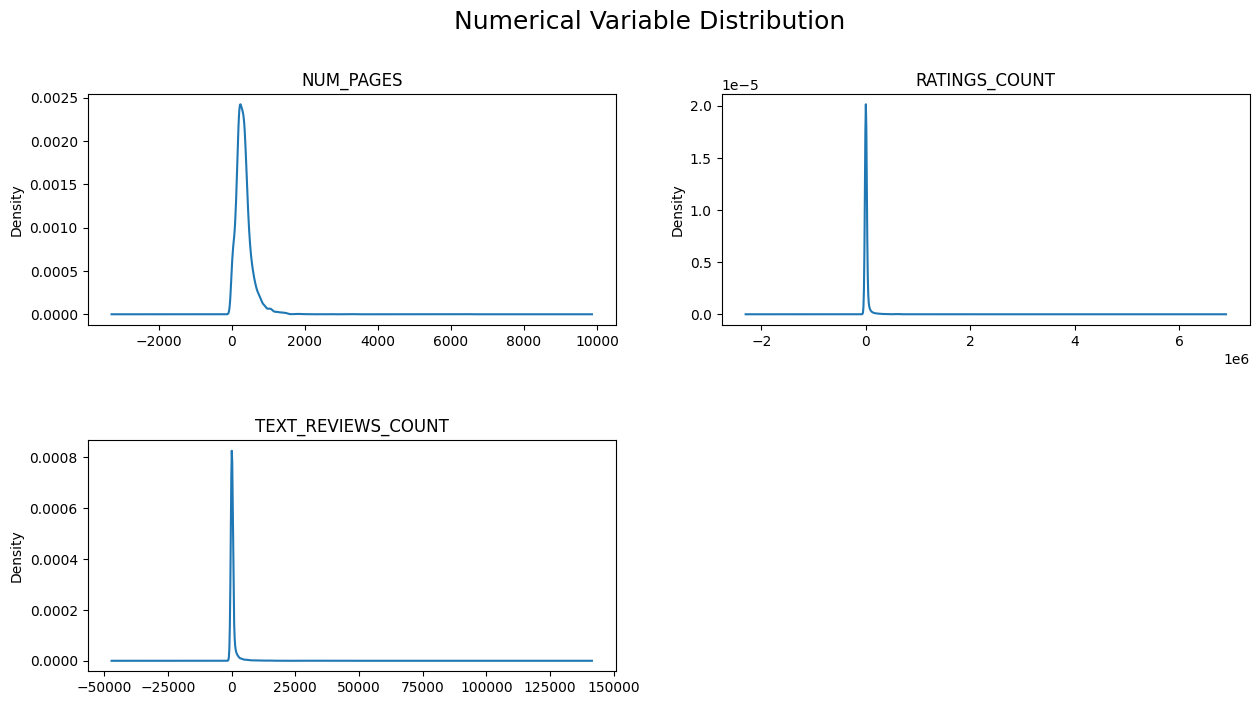

In [9]:
#Examine the density plots of numerical variables
numerical_cols = list(goodreads_df.select_dtypes(include=[int, float]).columns)
numerical_cols.remove("bookID")
numerical_cols.remove("average_rating")

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Numerical Variable Distribution", fontsize=18, y=0.95)

#Generate the subplots
for n, column in enumerate(numerical_cols):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
    # filter df and plot ticker on the new subplot axis
    goodreads_df[column].plot(ax=ax, kind="kde")

    # chart formatting
    ax.set_title(column.upper())
    ax.set_xlabel("")

**2c) Check text data**

In [10]:
# Getting descriptive statistics for the text part of the dataset
non_numeric_columns = goodreads_df.select_dtypes(include=['object'])
non_numeric_descriptive_table = non_numeric_columns.describe().transpose()
non_numeric_descriptive_table

count unique            top  freq
title             11127  10352      The Iliad     9
authors           11127   6643   Stephen King    40
isbn              11127  11127     0439785960     1
isbn13            11127  11127  9780439785969     1
language_code     11127     27            eng  8911
publication_date  11127   3679      10/1/2005    56
publisher         11127   2293        Vintage   318

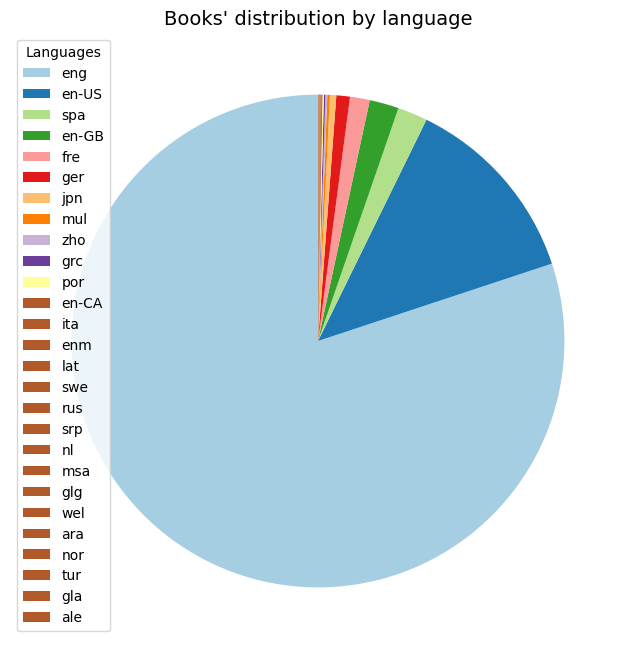

In [11]:
# Count the occurrences of each language
language_counts = goodreads_df['language_code'].value_counts()
 
# Create a color palette for the pie chart
colors = plt.cm.Paired(range(len(language_counts)))
 
# Create a pie chart with better formatting
plt.figure(figsize=(8, 8))  # Set the figure size
pie = plt.pie(language_counts, labels=None, autopct='', startangle=90, colors=colors)
 
# Add a title
plt.title("Books' distribution by language", fontsize=14)
 
# Create a legend with language labels using the original language counts
plt.legend(language_counts.index, title='Languages', loc='best')
 
# Remove labels from the pie chart
for wedge in pie[0]:
    wedge.set_label('')
 
# Display the chart
plt.show()

### **3) DATA CLEANING (CASE, ACCENTS, EXTRA SPACES, UNIQUE AUTHORS/PUBLISHERS, REMOVING BAD DATA)**

**3a) Make a copy of the dataframe and clean the copy (keeps the initial data untouched)**

In [12]:
dfGRcleaned = goodreads_df.copy()

**3b) Correct publisher names, eliminate excess spaces, remove accents in latin characters, and make text lowercase**

In [13]:
#Function to clean text and group publishers
def cleaning(dataframe, col_names):
    #1- object variables -> lowercase, spaces, accents
    columns = col_names
    regex = r"[a-z-A-Z-0-9]"
    for column in columns:
        dataframe[column] = dataframe[column].map(str.lower)
        dataframe[column] = dataframe[column].apply(lambda x: x.strip())
        dataframe[column] = dataframe[column].apply(lambda x: replace_accents_characters(x) if re.match(regex, x) else x)
    #2- publisher variable -> cleaning publisher variable (hidden duplicate values)
    publishers_list = ["penguin","bantam","giroux","harcourt","harlequin","routledge","morrow","harper","berkley","bloomsbury",
                   "scholastic", "collin","ecco","farrar","grove","harvard","headline","heinemann","hodder","houghton",
                   "larousse","loeb", "macmillan","mcgraw","minnesota","nelson","prentice", "alfaguara", "bedford", "cambridge",
                  "columbia", "fawcett", "focu", "grand central", "brown", "metropolitan", "prima", "puzzle", "reclam",
                   "schuster", "rowohlt", "silhouette", "viking", "vintage", "york", "random house", "1st world library", "1st book library"]
    dict_noisy_words = {"book" : "", "livre" : "", "publishing" : "", "publisher" : "", "pres" : "", "company" : "", "hardcover" : "", "paperback" : "", "busines" : "",
                  "corporation" : "", "editorial" : "", "professional" : "", "university": "", "univ" : "", "library" : "", "academy" : "", "academic" : "",
                  "associate" : "", "communication" : "", "association" : "", "group" : "", "society" : "", "random" : "", "america" : "", "international" : "", "world" : "", 
                  "carolina": "", "edition": "", "editorial": "", "edicione" : "", "edicion" : "", "editore": "", "publication" : "", "production" : "", "classic" : "", "young reader" : "", "group" : "", "audio" : "", "digital" : "", "overlook" : "", "media" : "",
                  "overlook" : "", "limited" : "", "anchor" : "", "forum" : "", "histoire" : "", "education" : "", "jeunesse" : "", "littérature" : "", "children" : "", 
                  "comic" : "", "manga" : "", "kid" : "", "adult" : "", "house" : "", "corp" : "","ubns" : "",  "publ" : "", "inc" : "", "llc" : "", "ltd" : ""}
    dataframe["publisher"] = dataframe["publisher"].apply(lambda x: x.strip()) #all the blank spaces at the stard and the end
    dataframe.replace({"publisher" : {r"\([^)]*\)" : "()", r"\W" : " ", r"(?<=[^\s])[s](\b)" : "", 
                                     r"(^.\s)" : "", r"(?<=\s).(?=\s)" : "", r"(?<=\s).$" : "", r"\s+" : " "}}, inplace=True, regex=True) #all the terms in parentheses, special characters and letter "s" at the end of each words all single characters at different places + all the multiple blank spaces
    for name in publishers_list:
        [name for publisher_text in dataframe["publisher"] if publisher_text.__contains__(name)]
    for key, value in dict_noisy_words.items():
        dataframe["publisher"] = dataframe["publisher"].apply(lambda x: x.replace(key, value) if (" " in x) == True else x)
        dataframe["publisher"] = dataframe["publisher"].apply(lambda x: x.strip()) #replace noisy words
    dataframe["publisher"] = dataframe["publisher"].apply(lambda x: x.strip()) #all the blank spaces at the stard and the end
    return dataframe

In [14]:
#Apply the cleaning function to certain columns
col_names = ["authors", "title", "language_code", "publisher"] 
dfGRcleaned = cleaning(dfGRcleaned, col_names)
dfGRcleaned.tail(2)

bookID                                              title  \
11125   22128                     patriots (the coming collapse)   
11126   34889  brown's star atlas: showing all the bright sta...   

                     authors  average_rating        isbn         isbn13  \
11125   james wesley, rawles            3.63  156384155X  9781563841552   
11126  brown, son & ferguson            0.00  0851742718  9780851742717   

      language_code  num_pages  ratings_count  text_reviews_count  \
11125           eng        342             38                   4   
11126           eng         49              0                   0   

      publication_date           publisher  
11125        1/15/1999          huntington  
11126         5/1/1977  brown son ferguson

**3c) Correct dates**

In [15]:
#Function to reformat the dates
#df = dataframe
#dfColName = name of the column to date reformat
#formatIn = date style of input data, '%m/%d/%Y' for example
#formatOut = date style of output data, '%Y/%m/%d' for example
def formatDate(df, dfColName: str, formatIn: str, formatOut: str):
    newdateArray = [] #list that will contain the corrected dates, stored sequentially in the same order as the dataframe
    counter = 0 #counter used to keep track of row number
    errorPositions = []
    #Dates the dates as text and then split into a list which can then be made into a datetime object
    #Example: "5/1/1977" is transformed into ['5', '1', '1977'] via the split command
    for i in df[dfColName]:
        date_text = i
        date_text.split("/")
        try:
            date_obj = datetime.strptime(date_text, formatIn)
        except:
            #Error lines must be shown
            print("DATETIME ERROR AT ROW", counter, "\t-->", "\tTHE CORRESPONDING DATE IS", dfGRcleaned.publication_date[counter])
            errorPositions.append(counter)
        date_obj.strftime(formatOut)
        newdateArray.append(date_obj)
        counter += 1 #update counter
    #Jupyter notebook printout of rows within the dataframe that are errors:
    display(df.iloc[errorPositions])
    return newdateArray

In [16]:
#Try a first conversion of dates to the desired format
formattedDate = formatDate(dfGRcleaned, dfColName = "publication_date", formatIn = '%m/%d/%Y', formatOut = '%Y/%m/%d')

DATETIME ERROR AT ROW 8177 	--> 	THE CORRESPONDING DATE IS 11/31/2000
DATETIME ERROR AT ROW 11094 	--> 	THE CORRESPONDING DATE IS 6/31/1982


bookID                                              title  \
8177    31373  in pursuit of the proper sinner (inspector lyn...   
11094   45531         montaillou  village occitan de 1294 a 1324   

                                               authors  average_rating  \
8177                                 elizabeth  george            4.10   
11094  emmanuel le roy ladurie/emmanuel le roy-ladurie            3.96   

             isbn         isbn13 language_code  num_pages  ratings_count  \
8177   0553575104  9780553575101           eng        718          10608   
11094  2070323285  9782070323289           fre        640             15   

       text_reviews_count publication_date publisher  
8177                  295       11/31/2000    bantam  
11094                   2        6/31/1982     folio

In [17]:
#Fix the dates at the indexes where the errors appeared:
dfGRcleaned.at[8177, 'publication_date'] = "10/31/2000"
dfGRcleaned.at[11094, 'publication_date'] = "6/30/1982"

#Convert the date formats again and overwrite the existing dates with the new format
formattedDate = formatDate(dfGRcleaned, dfColName = "publication_date", formatIn = '%m/%d/%Y', formatOut = '%Y/%m/%d')
dfGRcleaned.publication_date = pd.DataFrame(formattedDate)
dfGRcleaned.head(2)

Empty DataFrame
Columns: [bookID, title, authors, average_rating, isbn, isbn13, language_code, num_pages, ratings_count, text_reviews_count, publication_date, publisher]
Index: []

bookID                                              title  \
0       1  harry potter and the half-blood prince (harry ...   
1       2  harry potter and the order of the phoenix (har...   

                      authors  average_rating        isbn         isbn13  \
0  j.k. rowling/mary grandpre            4.57  0439785960  9780439785969   
1  j.k. rowling/mary grandpre            4.49  0439358078  9780439358071   

  language_code  num_pages  ratings_count  text_reviews_count  \
0           eng        652        2095690               27591   
1           eng        870        2153167               29221   

  publication_date   publisher  
0       2006-09-16  scholastic  
1       2004-09-01  scholastic

In [18]:
#Check the most recent publication date
dfGRcleaned.publication_date.max()

Timestamp('2020-03-31 00:00:00')

**3d) Split out first author**

In [19]:
#Create a splitAuthors dataframe where the text is split at the first occurence of the separator '/'
#This gives three columns, the middle column containing only the separator
dfSplitAuthors = dfGRcleaned["authors"].str.partition(sep="/", expand = True)
#Drop the separator column (column 1)
dfSplitAuthors = dfSplitAuthors.drop([1], axis=1)
#Rename the remaining columns
dfSplitAuthors.columns = ["first_author", "other_participants"]
#Add other pertinent information (original full authors data + bookID
dfSplitAuthors["full_author_list"] = dfGRcleaned["authors"]
dfSplitAuthors["bookID"] = dfGRcleaned["bookID"]
dfSplitAuthors.tail(5)

first_author  \
11122                                         mark twain   
11123                               sam bass warner, jr.   
11124  david e. smith (turgon of theonering.net, one ...   
11125                               james wesley, rawles   
11126                              brown, son & ferguson   

                            other_participants  \
11122                                            
11123                            sam b. warner   
11124  verlyn flieger/turgon (=david e. smith)   
11125                                            
11126                                            

                                        full_author_list  bookID  
11122                                         mark twain   45641  
11123                 sam bass warner, jr./sam b. warner   12224  
11124  david e. smith (turgon of theonering.net, one ...   16914  
11125                               james wesley, rawles   22128  
11126                              brown, son & ferguson   34889

In [20]:
#Merge with the main dataframe, but only keep the first_author
dfGRcleaned = dfGRcleaned.merge(dfSplitAuthors[["first_author", "bookID"]], how = "inner", left_on = "bookID", right_on = "bookID")
dfGRcleaned.tail(5)

bookID                                              title  \
11122   45641                        las aventuras de tom sawyer   
11123   12224  streetcar suburbs: the process of growth in bo...   
11124   16914                  the tolkien fan's medieval reader   
11125   22128                     patriots (the coming collapse)   
11126   34889  brown's star atlas: showing all the bright sta...   

                                                 authors  average_rating  \
11122                                         mark twain            3.91   
11123                 sam bass warner, jr./sam b. warner            3.58   
11124  david e. smith (turgon of theonering.net, one ...            3.58   
11125                               james wesley, rawles            3.63   
11126                              brown, son & ferguson            0.00   

             isbn         isbn13 language_code  num_pages  ratings_count  \
11122  8497646983  9788497646987           spa        272            113   
11123  0674842111  9780674842113         en-us        236             61   
11124  1593600119  9781593600112           eng        400             26   
11125  156384155X  9781563841552           eng        342             38   
11126  0851742718  9780851742717           eng         49              0   

       text_reviews_count publication_date           publisher  \
11122                  12       2006-05-28        edimat libro   
11123                   6       2004-04-20             harvard   
11124                   4       2004-04-06         cold spring   
11125                   4       1999-01-15          huntington   
11126                   0       1977-05-01  brown son ferguson   

                                            first_author  
11122                                         mark twain  
11123                               sam bass warner, jr.  
11124  david e. smith (turgon of theonering.net, one ...  
11125                               james wesley, rawles  
11126                              brown, son & ferguson

**3e) Purge books that have too few reviews (bad quality data)**

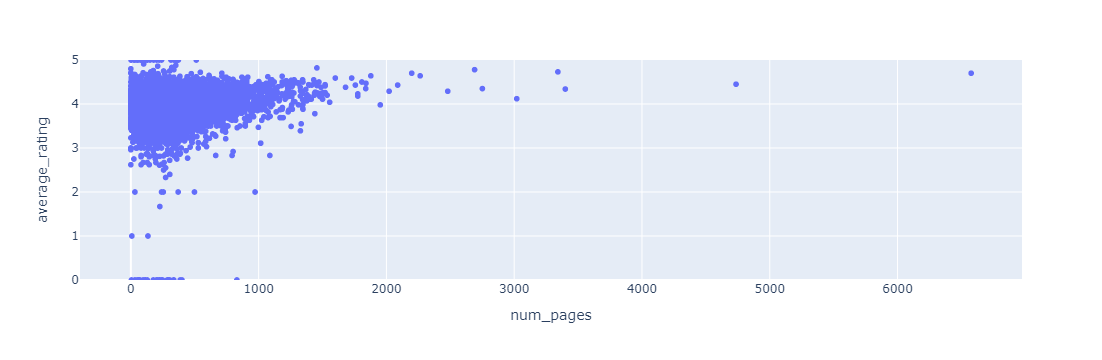

In [21]:
#Plot average_rating against num_pages to get a distribution that is easy to to see (plotting against ratings_count gives a plot that is too tight):
fig = px.scatter(dfGRcleaned, x = "num_pages", y = "average_rating")
fig.update_yaxes(range=[0, 5])
fig.show()

In [22]:
#Drop rows with fewer than 7 reviews
lowerLimit = 7
print("NUMBER OF REMOVED ROWS =", len(dfGRcleaned[dfGRcleaned.ratings_count < lowerLimit]))
dfGRcleaned.drop(dfGRcleaned[dfGRcleaned.ratings_count < lowerLimit].index, inplace = True)

NUMBER OF REMOVED ROWS = 499


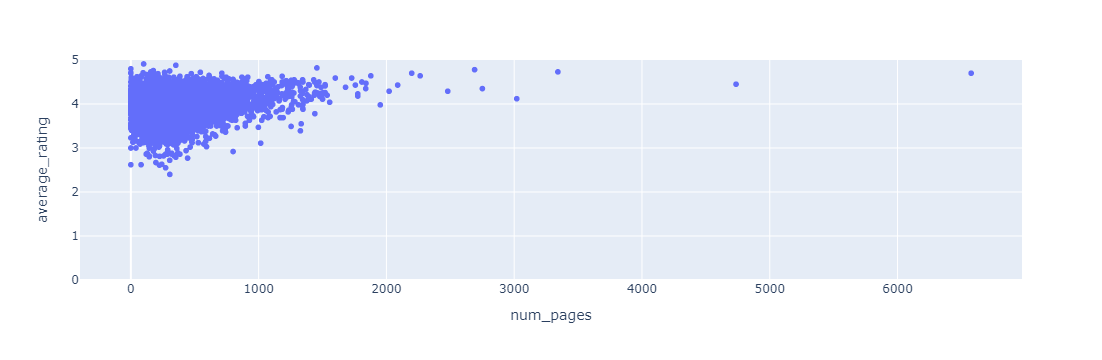

In [23]:
#Check the result against num_pages, are there still average ratings of zero or five?
fig = px.scatter(dfGRcleaned, x = "num_pages", y = "average_rating")
fig.update_yaxes(range=[0, 5])
fig.show()

### **4) FEATURE ENGINEERING**

**4a) Add a column showing how many books have been published by the author**

In [24]:
#Create a dictionary to store the number of books published by each author
dict_author_pub_book_qty = dfGRcleaned["first_author"].value_counts().to_dict()

#Add books published as a new column
dfGRcleaned["books_by_main_author"] = dfGRcleaned["first_author"].replace(dict_author_pub_book_qty)

#Show the dictionary entries
#dict_author_pub_book_qty

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9980\2162888339.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



**4b) Add a column showing how many books have been published by the publisher**

In [25]:
#Create a dictionary to store the number of books published by each author
dict_publisher_pub_book_qty = dfGRcleaned["publisher"].value_counts().to_dict()

#Add books published as a new column
dfGRcleaned["books_by_publisher"] = dfGRcleaned["publisher"].replace(dict_publisher_pub_book_qty)

#Show the dictionary entries
#dict_publisher_pub_book_qty

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9980\458754187.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



**4c) Categorize the languages**

In [26]:
#Check the language counts
dfGRcleaned["language_code"].value_counts()

language_code
eng      8577
en-us    1385
en-gb     208
spa       185
fre       105
ger        64
jpn        35
mul        19
por        10
en-ca       7
zho         6
grc         5
ita         5
enm         3
lat         3
rus         2
nor         1
gla         1
tur         1
swe         1
nl          1
glg         1
msa         1
ara         1
ale         1
Name: count, dtype: int64

In [27]:
#Replace English variantes with 1
dfGRcleaned["language_code"].replace(to_replace = ["en-us", "en-gb", "en-ca"], value = 1, inplace = True)

#Replace all other languages with 0
dfGRcleaned["language_code"] = [0 if language != 1 else 1 for language in dfGRcleaned["language_code"] ]
dfGRcleaned.tail()

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9980\450762577.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





bookID                                              title  \
11121   45639                                        poor people   
11122   45641                        las aventuras de tom sawyer   
11123   12224  streetcar suburbs: the process of growth in bo...   
11124   16914                  the tolkien fan's medieval reader   
11125   22128                     patriots (the coming collapse)   

                                                 authors  average_rating  \
11121                                william t. vollmann            3.72   
11122                                         mark twain            3.91   
11123                 sam bass warner, jr./sam b. warner            3.58   
11124  david e. smith (turgon of theonering.net, one ...            3.58   
11125                               james wesley, rawles            3.63   

             isbn         isbn13  language_code  num_pages  ratings_count  \
11121  0060878827  9780060878825              0        434            769   
11122  8497646983  9788497646987              0        272            113   
11123  0674842111  9780674842113              1        236             61   
11124  1593600119  9781593600112              0        400             26   
11125  156384155X  9781563841552              0        342             38   

       text_reviews_count publication_date     publisher  \
11121                 139       2007-02-27          ecco   
11122                  12       2006-05-28  edimat libro   
11123                   6       2004-04-20       harvard   
11124                   4       2004-04-06   cold spring   
11125                   4       1999-01-15    huntington   

                                            first_author  \
11121                                william t. vollmann   
11122                                         mark twain   
11123                               sam bass warner, jr.   
11124  david e. smith (turgon of theonering.net, one ...   
11125                               james wesley, rawles   

       books_by_main_author  books_by_publisher  
11121                     6                  22  
11122                    29                   4  
11123                     1                  39  
11124                     1                   2  
11125                     1                   1

**4d) Add a column for length of the book title**

In [28]:
#Calculate number of characters (spaces included) for each title
dfGRcleaned["length_title"] = dfGRcleaned["title"].apply(lambda x: len(x))
dfGRcleaned.head(2)

bookID                                              title  \
0       1  harry potter and the half-blood prince (harry ...   
1       2  harry potter and the order of the phoenix (har...   

                      authors  average_rating        isbn         isbn13  \
0  j.k. rowling/mary grandpre            4.57  0439785960  9780439785969   
1  j.k. rowling/mary grandpre            4.49  0439358078  9780439358071   

   language_code  num_pages  ratings_count  text_reviews_count  \
0              0        652        2095690               27591   
1              0        870        2153167               29221   

  publication_date   publisher  first_author  books_by_main_author  \
0       2006-09-16  scholastic  j.k. rowling                    24   
1       2004-09-01  scholastic  j.k. rowling                    24   

   books_by_publisher  length_title  
0                 122            57  
1                 122            60

**4e) Add a column for number of authors/participants**

In [29]:
#Count the number slashes and add 1 -> this provides the number of authors/participants
dfGRcleaned["nb_authors"] = dfGRcleaned["authors"].apply(lambda x: 1 + x.count("/"))
dfGRcleaned.head(2)

bookID                                              title  \
0       1  harry potter and the half-blood prince (harry ...   
1       2  harry potter and the order of the phoenix (har...   

                      authors  average_rating        isbn         isbn13  \
0  j.k. rowling/mary grandpre            4.57  0439785960  9780439785969   
1  j.k. rowling/mary grandpre            4.49  0439358078  9780439358071   

   language_code  num_pages  ratings_count  text_reviews_count  \
0              0        652        2095690               27591   
1              0        870        2153167               29221   

  publication_date   publisher  first_author  books_by_main_author  \
0       2006-09-16  scholastic  j.k. rowling                    24   
1       2004-09-01  scholastic  j.k. rowling                    24   

   books_by_publisher  length_title  nb_authors  
0                 122            57           2  
1                 122            60           2

**4f) Make a column for author's average rating and for publisher's average rating**

In [30]:
#Author average rating
avg_author_rating_dict = dfGRcleaned.groupby(["first_author"])["average_rating"].mean().to_dict() #Each author gets a single dictionary entry
dfGRcleaned["avg_author_rating"] = dfGRcleaned["first_author"].replace(avg_author_rating_dict) #The dictionary is used to create a new column

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9980\273423009.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [31]:
#Publisher average rating
avg_publisher_rating_dict = dfGRcleaned.groupby(["publisher"])["average_rating"].mean().to_dict() #Each publisher gets a single dictionary entry
dfGRcleaned["avg_publisher_rating"] = dfGRcleaned["publisher"].replace(avg_publisher_rating_dict)  #The dictionary is used to create a new column
dfGRcleaned.head(2)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9980\3198321016.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



bookID                                              title  \
0       1  harry potter and the half-blood prince (harry ...   
1       2  harry potter and the order of the phoenix (har...   

                      authors  average_rating        isbn         isbn13  \
0  j.k. rowling/mary grandpre            4.57  0439785960  9780439785969   
1  j.k. rowling/mary grandpre            4.49  0439358078  9780439358071   

   language_code  num_pages  ratings_count  text_reviews_count  \
0              0        652        2095690               27591   
1              0        870        2153167               29221   

  publication_date   publisher  first_author  books_by_main_author  \
0       2006-09-16  scholastic  j.k. rowling                    24   
1       2004-09-01  scholastic  j.k. rowling                    24   

   books_by_publisher  length_title  nb_authors  avg_author_rating  \
0                 122            57           2            4.52125   
1                 122            60           2            4.52125   

   avg_publisher_rating  
0              3.951967  
1              3.951967

**4g) Split the date column into quarter, month, and year columns**

In [32]:
# Make sure 'publication_date' is in datetime format
dfGRcleaned['publication_date'] = pd.to_datetime(dfGRcleaned['publication_date'], errors='coerce')
 
# Extracting the year and month from the publication date
dfGRcleaned['year'] = dfGRcleaned['publication_date'].dt.year
dfGRcleaned['month'] = dfGRcleaned['publication_date'].dt.month
 
# Adding a quarter column
dfGRcleaned['quarter'] = dfGRcleaned['publication_date'].dt.quarter
 
# Display the first few rows to check the new columns
print(dfGRcleaned[['publication_date', 'year', 'month', 'quarter']].head())

  publication_date  year  month  quarter
0       2006-09-16  2006      9        3
1       2004-09-01  2004      9        3
2       2003-11-01  2003     11        4
3       2004-05-01  2004      5        2
4       2004-09-13  2004      9        3


### **5) EXPLORATORY DATA ANALYSIS (POST-CLEANING)**

**5a) Check all data**

In [33]:
# Getting descriptive statistics for the numeric part of the dataset
dfGRcleaned.describe().transpose()

count                           mean  \
bookID                10628.0                   21197.001129   
average_rating        10628.0                        3.94572   
language_code         10628.0                       0.150546   
num_pages             10628.0                     339.945898   
ratings_count         10628.0                   18778.418235   
text_reviews_count    10628.0                     567.279356   
publication_date        10628  2000-09-17 14:40:17.162212992   
books_by_main_author  10628.0                      10.080166   
books_by_publisher    10628.0                      85.817463   
length_title          10628.0                       35.47516   
nb_authors            10628.0                        1.72309   
avg_author_rating     10628.0                        3.94572   
avg_publisher_rating  10628.0                        3.94572   
year                  10628.0                    2000.222525   
month                 10628.0                       6.564641   
quarter               10628.0                       2.530956   

                                      min                  25%  \
bookID                                1.0             10168.75   
average_rating                        2.4                 3.78   
language_code                         0.0                  0.0   
num_pages                             0.0               199.75   
ratings_count                         7.0                144.0   
text_reviews_count                    0.0                 11.0   
publication_date      1900-01-01 00:00:00  1998-08-02 12:00:00   
books_by_main_author                  1.0                  2.0   
books_by_publisher                    1.0                  8.0   
length_title                          2.0                 18.0   
nb_authors                            1.0                  1.0   
avg_author_rating                    2.55             3.812431   
avg_publisher_rating                 2.67             3.883226   
year                               1900.0               1998.0   
month                                 1.0                  4.0   
quarter                               1.0                  2.0   

                                      50%                  75%  \
bookID                            19982.0             31940.25   
average_rating                       3.96                 4.13   
language_code                         0.0                  0.0   
num_pages                           304.0                416.0   
ratings_count                       873.5              5521.75   
text_reviews_count                   53.0                257.0   
publication_date      2003-03-04 00:00:00  2005-10-01 00:00:00   
books_by_main_author                  5.0                 12.0   
books_by_publisher                   33.0                 99.0   
length_title                         30.0                 47.0   
nb_authors                            1.0                  2.0   
avg_author_rating                3.953333                 4.09   
avg_publisher_rating             3.924699             4.000137   
year                               2003.0               2005.0   
month                                 7.0                 9.25   
quarter                               3.0                 3.25   

                                      max           std  
bookID                            45641.0   13083.93248  
average_rating                       4.91      0.278124  
language_code                         1.0      0.357622  
num_pages                          6576.0    239.714134  
ratings_count                   4597666.0  115021.22424  
text_reviews_count                94265.0    2633.23025  
publication_date      2020-03-31 00:00:00           NaN  
books_by_main_author                 88.0     13.773496  
books_by_publisher                  564.0    137.035456  
length_title                        254.0     23.466993  
nb_authors                           51.0      1.81

**5b) Check nemerical data**

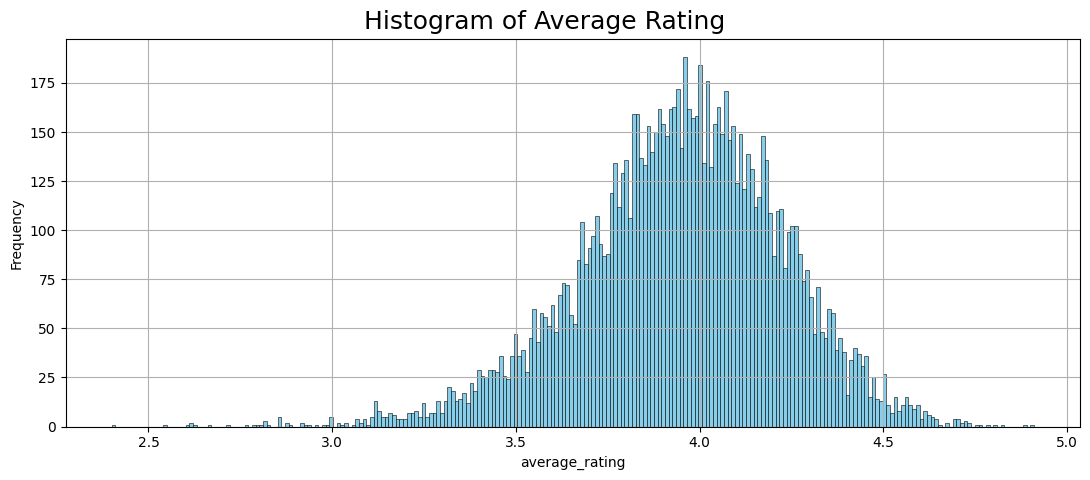

In [34]:
#Get the histogram of the average_rating to see how the removal of data changed the distribution
numerical_cols = ["average_rating"]

plt.figure(figsize=(11, 5))
plt.suptitle("Histogram of Average Rating", fontsize=18, y=0.95)
for i, column in enumerate(numerical_cols):
    plt.subplot(1, 1, i + 1)
    dfGRcleaned[column].hist(bins=250, color='skyblue', edgecolor='black', linewidth=0.4)
    #plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

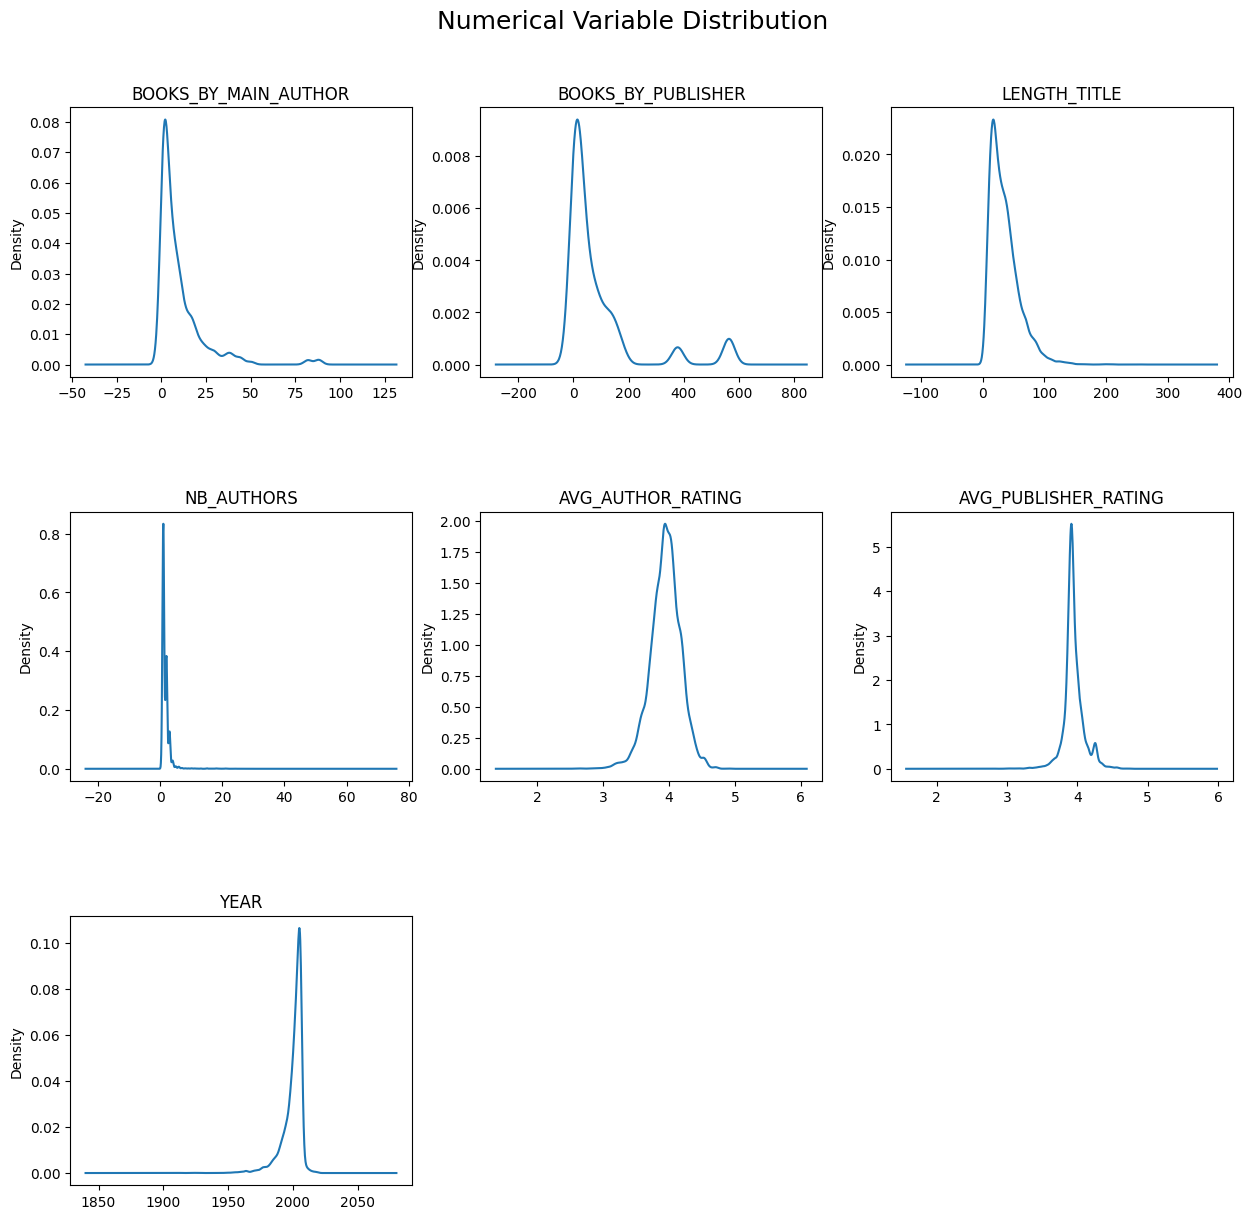

In [35]:
#Examine the density plots of numerical variables
numerical_cols = list(dfGRcleaned.select_dtypes(include=[int, float]).columns)
numerical_cols.remove("bookID")
numerical_cols.remove("language_code")
numerical_cols.remove("month")
numerical_cols.remove("quarter")
numerical_cols.remove("average_rating")
numerical_cols.remove("num_pages")
numerical_cols.remove("ratings_count")
numerical_cols.remove("text_reviews_count")


#Examine the density plots of numerical variables
plt.figure(figsize=(15, 14))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Numerical Variable Distribution", fontsize=18, y=0.95)

for n, column in enumerate(numerical_cols):
    # add a new subplot iteratively
    ax = plt.subplot(3, 3, n + 1)
    # filter df and plot ticker on the new subplot axis
    dfGRcleaned[column].plot(ax=ax, kind="kde")

    # chart formatting
    ax.set_title(column.upper())
    ax.set_xlabel("")

**5c) Check categorical data**

In [36]:
# Getting descriptive statistics for the categorical and text part of the dataset
non_numeric_columns = dfGRcleaned.select_dtypes(include=['object'])
non_numeric_descriptive_table = non_numeric_columns.describe().transpose()
non_numeric_descriptive_table

count unique                  top freq
title         10628   9844            the iliad    9
authors       10628   6316         stephen king   40
isbn          10628  10628           0439785960    1
isbn13        10628  10628        9780439785969    1
publisher     10628   1615              penguin  564
first_author  10628   3999  william shakespeare   88

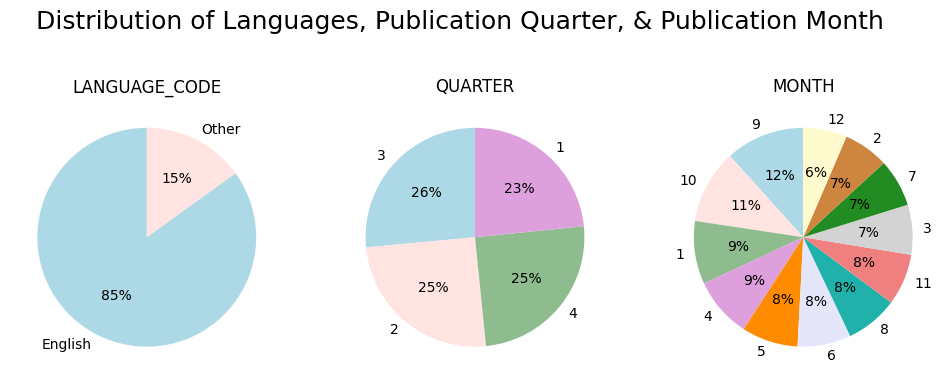

In [37]:
#Check the distribution of categorical variables via pie charts: language, quarter, and month
categorical_cols_for_pie = ["language_code", "quarter", "month"]

#Create the plotting parameters
plt.figure(figsize=(12, 5))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of Languages, Publication Quarter, & Publication Month", fontsize=18, y=0.95)
colors =(["lightblue","mistyrose","darkseagreen","plum","darkorange","lavender",
          "lightseagreen","lightcoral", "lightgrey","forestgreen","peru","lemonchiffon"]) 
title = ["Languages", "Quarter", "Month"]

#Create a subplot for each categorical variable
for n, column in enumerate(categorical_cols_for_pie):
    # position in plot
    ax = plt.subplot(1, 3, n + 1)
    # chart formatting
    ax.set_title(column.upper())

    # Create a  smaller pie chart with better formatting
    list_valuecounts = dfGRcleaned[column].value_counts()
    labels = list_valuecounts.index
    if n == 0:
        if labels[0] == 0:
            labels = ["English", "Other"]
        else:
            labels = ["Other", "English"]
    plt.pie(list_valuecounts, labels=labels, startangle=90, colors=colors, autopct='%1.0f%%', textprops={'fontsize': 10})

**5d) Examine the correlations of between variables**

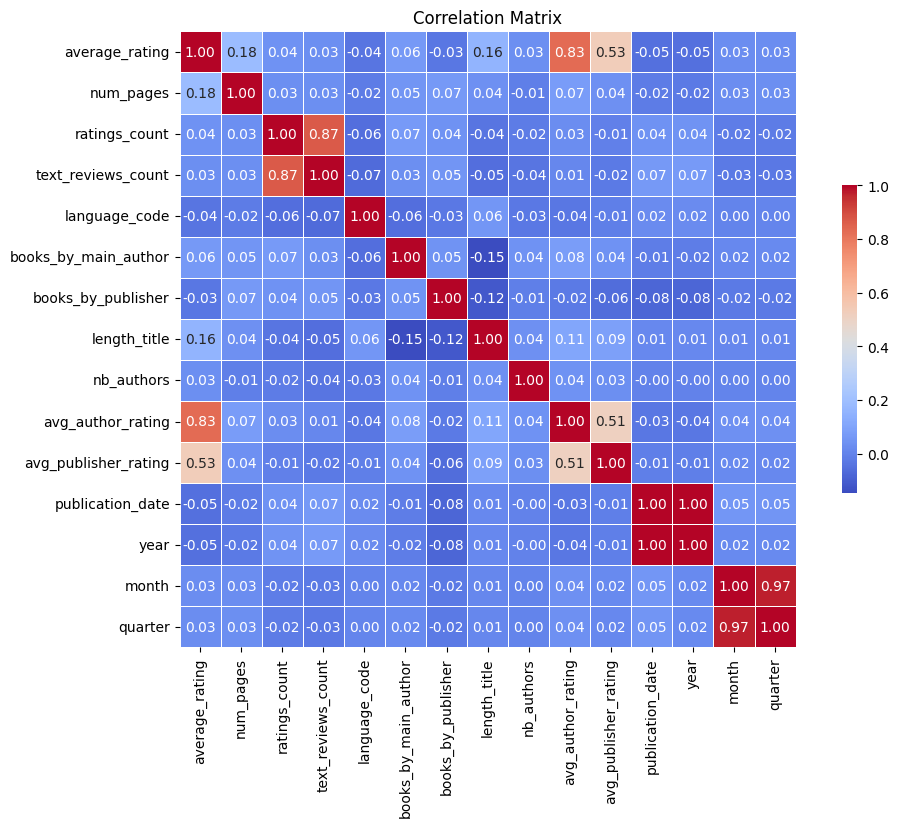

In [38]:
# Calculating the correlation matrix for the numeric data (including some categorical data)
col_names = ["average_rating", "num_pages", "ratings_count", "text_reviews_count", "language_code",
             "books_by_main_author", "books_by_publisher", "length_title",
            "nb_authors", "avg_author_rating", "avg_publisher_rating",  "publication_date", "year", "month", "quarter"]
correlation_matrix = dfGRcleaned[col_names].corr()

#Set figure size
plt.figure(figsize=(12, 8))
#Make the heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

### **6) REMOVE OUTLIERS *(USED DURING ANALYSIS, BUT NOT FOR FINAL MODEL)***

In [39]:
#Examine the books with too many pages using the z-score statistical approach (in general +/- 3 is too high)
dfGRcleaned['z_scores_num_pages'] = stats.zscore(dfGRcleaned.num_pages, axis=0)

#Remove the books with too many pages
#dfGRcleaned.drop(dfGRcleaned[dfGRcleaned['z_scores_num_pages'] > 7].index, inplace = True)

### **7) TRANSFORMATION INTO COMPUTER USABLE DATA**

**7a) Drop the columns that are not needed**

In [40]:
#Make a copy for post-modelization analysis
dfGRcleaned_copy = dfGRcleaned.copy()

#Drop the columns that will not be used in any model
dfGRcleaned.drop(labels=["title","authors","isbn","isbn13", "text_reviews_count", "publisher", "first_author", "publication_date", "quarter", "z_scores_num_pages"], axis=1, inplace=True)

**7b) Treat the ratings_count with a logarithmic function so it performs better in the models**

Text(0, 0.5, 'Frequency')

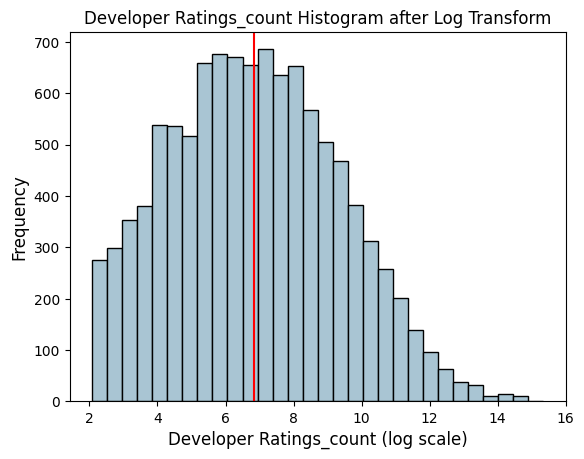

In [41]:
#Apply a logarithmic function to the ratings_count and add it as a new column
dfGRcleaned['ratings_count_log'] = np.log((1+ dfGRcleaned['ratings_count']))

#Calculate the mean of the transformed ratings_count and round it
ratings_count_log_mean = np.round(np.mean(dfGRcleaned['ratings_count_log']), 2)

#Plot the results
fig, ax = plt.subplots()
dfGRcleaned['ratings_count_log'].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
plt.axvline(ratings_count_log_mean, color='r')
ax.set_title('Developer Ratings_count Histogram after Log Transform', 
             fontsize=12)
ax.set_xlabel('Developer Ratings_count (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
#ax.text(11.5, 450, r'$\mu$='+str(rating_log_mean), fontsize=10)

**7c) Normalize and standardize the data**

In [42]:
#Normalize certain columns to prevent them from skewing the model (make into a Gaussian distribution)
cols_to_normalize = ["num_pages", "ratings_count", "books_by_main_author", "books_by_publisher",
               "length_title", "nb_authors", "avg_author_rating", "avg_publisher_rating", "year", "month"]
cols_to_standardize = ['ratings_count_log']

#Use MinMaxScaler and StandardScaler
dfGRcleaned[cols_to_normalize] = MinMaxScaler().fit_transform(dfGRcleaned[cols_to_normalize])
dfGRcleaned[cols_to_standardize] = StandardScaler().fit_transform(dfGRcleaned[cols_to_standardize])
dfGRcleaned.head(8)

bookID  average_rating  language_code  num_pages  ratings_count  \
0       1            4.57              0   0.099148       0.455815   
1       2            4.49              0   0.132299       0.468317   
2       4            4.42              0   0.053528       0.001376   
3       5            4.56              0   0.066150       0.508863   
4       8            4.78              0   0.409063       0.009009   
5       9            3.74              1   0.023114       0.000003   
6      10            4.73              0   0.508212       0.006141   
7      12            4.38              0   0.123936       0.000788   

   books_by_main_author  books_by_publisher  length_title  nb_authors  \
0              0.264368            0.214920      0.218254        0.02   
1              0.264368            0.214920      0.230159        0.02   
2              0.264368            0.214920      0.222222        0.00   
3              0.264368            0.214920      0.226190        0.02   
4              0.264368            0.214920      0.206349        0.02   
5              0.000000            0.000000      0.337302        0.00   
6              0.264368            0.214920      0.166667        0.00   
7              0.195402            0.030195      0.420635        0.00   

   avg_author_rating  avg_publisher_rating      year     month  \
0           0.835275              0.580076  0.883333  0.727273   
1           0.835275              0.580076  0.866667  0.727273   
2           0.835275              0.580076  0.858333  0.909091   
3           0.835275              0.580076  0.866667  0.363636   
4           0.835275              0.580076  0.866667  0.727273   
5           0.504237              0.484163  0.875000  0.272727   
6           0.835275              0.580076  0.875000  0.727273   
7           0.707392              0.707642  0.875000  0.909091   

   ratings_count_log  
0           3.099795  
1           3.110686  
2           0.764426  
3           3.144110  
4           1.520399  
5          -1.553332  
6           1.366175  
7           0.540226

### **8) MODEL TESTING**

**8a) Create the train and test data sets**

In [43]:
#Create a list of columns to put in the X variables set (we remove the target variable)
cols_to_use = dfGRcleaned.columns.values.tolist()
cols_to_use.remove('average_rating')

In [44]:
#Shuffle the database
dfGRcleaned = dfGRcleaned.sample(frac=1, random_state=87)

#Make training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dfGRcleaned[cols_to_use], dfGRcleaned["average_rating"], test_size = 0.2, random_state = 5)

#Make a tracking of bookIDs and indexes for the training and testing data sets
df_training_bookIDs = pd.DataFrame(data=[[X_train[X_train["bookID"] == bookid].index.values[0], bookid] for bookid in X_train["bookID"]],
                  columns=["index","bookID"], index=None, copy=True)
df_testing_bookIDs = pd.DataFrame(data=[[X_test[X_test["bookID"] == bookid].index.values[0], bookid] for bookid in X_test["bookID"]],
                  columns=["index","bookID"], index=None, copy=True)

#Store an ordered set of bookIDs used in the training and testing sets
list_training_bookIDs = sorted(list(df_training_bookIDs["bookID"]))
list_testing_bookIDs = sorted(list(df_testing_bookIDs["bookID"]))

In [45]:
#Now remove the bookID from the training sets
X_train.drop(labels=["bookID"], axis=1, inplace=True)
X_test.drop(labels=["bookID"], axis=1, inplace=True)

In [46]:
#Verify that the means of the "average ratings" are very close (good split)
print(dfGRcleaned.average_rating.mean(), "--> mean rating of ORIGINAL dataframe")
print(y_train.mean(), "--> mean rating of TRAIN dataframe")
print(y_test.mean(), "--> mean rating of TEST dataframe")

3.945719796763267 --> mean rating of ORIGINAL dataframe
3.943318042813455 --> mean rating of TRAIN dataframe
3.9553245531514585 --> mean rating of TEST dataframe


In [47]:
#Verify that the means of the "ratings counts" are very close (good split)
print(dfGRcleaned.ratings_count.mean(), "--> mean number of ratings of ORIGINAL dataframe")
print(X_train.ratings_count.mean(), "--> mean number of ratings of TRAIN dataframe")
print(X_test.ratings_count.mean(), "--> mean number of ratings of TEST dataframe")

0.0040828208953407235 --> mean number of ratings of ORIGINAL dataframe
0.004074488951324885 --> mean number of ratings of TRAIN dataframe
0.004116140833262952 --> mean number of ratings of TEST dataframe


In [48]:
#Verify that the means of the "number of pages" are very close (good split)
print(dfGRcleaned.num_pages.mean(), "--> mean number of ratings of ORIGINAL dataframe")
print(X_train.num_pages.mean(), "--> mean number of ratings of TRAIN dataframe")
print(X_test.num_pages.mean(), "--> mean number of ratings of TEST dataframe")

0.05169493577081885 --> mean number of ratings of ORIGINAL dataframe
0.051649862262264326 --> mean number of ratings of TRAIN dataframe
0.05187518740286524 --> mean number of ratings of TEST dataframe


**8b) Try a polynomial regression model**

In [49]:
#The model is structured in the following way:
# -consider that every column in the dataframe will be tested in the model (the base feature set)
# -analyze variants by removing features from the base feature set
# -check the statistical results for each feature set
# -run the final feature set
# -run the permutations of the final feature set (cases where the author and/or publisher are new)
# -rerun the final feature set to have results available for analysis (note that every run is slightly different)

#First store the features to remove in the final model (this was added after checking which variants performed best)
final_features_list = ["ratings_count", "books_by_publisher", "language_code", "year", "month", "ratings_count_log"]

#Make a dictionary of features to remove from complete list where:
#Key = name of feature set (will be in the printout)
#Value = list of features to remove from base dataset
testing_features_to_remove = {
    "ALL FEATURES": "",
    "MINUS PUBLICATION DATE": ["year", "month"],
    "MINUS RATINGS COUNT": ["ratings_count"],
    "MINUS NUMBER OF BOOKS BY PUBLISHER": ["books_by_publisher"],
    "MINUS LANGUAGE CODE": ["language_code"],
    "FINAL FEATURES": final_features_list,
    "NEW AUTHOR": ["avg_author_rating"] + final_features_list,
    "NEW PUBLISHER": ["avg_publisher_rating"] + final_features_list,
    "NEW AUTHOR & PUBLISHER": ["avg_author_rating", "avg_publisher_rating"] + final_features_list,
    "RERUN FINAL FEATURES": final_features_list
}

#Evaluate the model for each feature set
print("## POLYNOMIAL REGRESSION RESULTS ##\n")
for key, value in testing_features_to_remove.items():
    #Get the column names of all the features in the base set
    listVariables_poly_regr = X_train.columns.values.tolist()
    
    #If the list of features to remove is NOT empty, then proceed towards their removal from the base set
    if value != "":
        cols_to_remove = value
        for colname in cols_to_remove:
            listVariables_poly_regr.remove(colname)
    
    #Crete an object with the polynomial function of the desired degree
    polytrans = PolynomialFeatures(degree = 2)
    
    #Generate the polynomial transform for the TRAINING set (using the selected variables)
    X_train_polynomial = polytrans.fit_transform(X_train[listVariables_poly_regr])
    
    #Generate the polynomial transform for the TEST set (using the selected variables)
    X_test_polynomial = polytrans.fit_transform(X_test[listVariables_poly_regr])
    
    #Make the linear regression object
    regr = linear_model.LinearRegression()
    #Train the model
    regr.fit(X_train_polynomial, y_train)
    #Make predictions
    y_predict = regr.predict(X_test_polynomial)
    
    #Calculate statistical results
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test, y_predict)
    R2_score = r2_score(y_test, y_predict) #R2 = coefficient of determination (perfect = 1, worst = 0)
    
    #Calculate the adjusted R2 score
    n = len(X_train[listVariables_poly_regr])
    p = len(X_train[listVariables_poly_regr].columns)
    adj_R2 = 1- ((1-R2_score) * (n-1)/(n-p-1))
    
    #Print statistical results for each feature set and list the features used
    print("---", key, "---", sep="")
    print("Mean squared error: %.3f" % MSE)
    print("Root mean squared error: %.3f" % RMSE)
    print("Mean absolute error: %.4f" % MAE)
    print("Coefficient of determination: %.3f" % R2_score)
    print("Adjusted R2-score: %.3f" % adj_R2)
    print()
    print("Minimum predicted score = %.2f" % y_predict.min(), sep="")
    print("Maximum predicted score = %.2f" % y_predict.max(), sep="")
    print()
    print("Features used:", listVariables_poly_regr)
    print()
#Print important information after the model runs
print("!!! THE OUTPUT OF <<", key, ">> IS THE ONLY OUTPUT ACCESSIBLE AFTER RUNNING THIS CODE !!!", sep="")
print()
print("NOTE:   The base model uses the avg_author_rating and the avg_publisher_rating features.\n",
        "\tThe same model cannot be used if the author and/or the publisher are new.\n",
        "\tThe avg_author_rating is removed if the author is new.\n",
        "\tThe avg_publisher_rating is removed if the publisher is new."
        )

## POLYNOMIAL REGRESSION RESULTS ##

---ALL FEATURES---
Mean squared error: 0.020
Root mean squared error: 0.142
Mean absolute error: 0.0988
Coefficient of determination: 0.741
Adjusted R2-score: 0.741

Minimum predicted score = 2.69
Maximum predicted score = 4.88

Features used: ['language_code', 'num_pages', 'ratings_count', 'books_by_main_author', 'books_by_publisher', 'length_title', 'nb_authors', 'avg_author_rating', 'avg_publisher_rating', 'year', 'month', 'ratings_count_log']

---MINUS PUBLICATION DATE---
Mean squared error: 0.020
Root mean squared error: 0.142
Mean absolute error: 0.0987
Coefficient of determination: 0.742
Adjusted R2-score: 0.741

Minimum predicted score = 2.69
Maximum predicted score = 4.87

Features used: ['language_code', 'num_pages', 'ratings_count', 'books_by_main_author', 'books_by_publisher', 'length_title', 'nb_authors', 'avg_author_rating', 'avg_publisher_rating', 'ratings_count_log']

---MINUS RATINGS COUNT---
Mean squared error: 0.020
Root mean squa

**8c) Try a random forest regression model**

In [50]:
# Model Pipeline - add more steps if necessary
model = Pipeline(steps=[
('regressor', RandomForestRegressor())
])

In [51]:
#The model is structured in the following way:
# -consider that every column in the dataframe will be tested in the model (the base feature set)
# -analyze variants by removing features from the base feature set
# -check the statistical results for each feature set
# -run the final feature set
# -run the permutations of the final feature set (cases where the author and/or publisher are new)
# -rerun the final feature set to have results available for analysis (note that every run is slightly different)

#First store the features to remove in the final model (this was added after checking which variants performed best)
final_features_list = ["ratings_count", "books_by_publisher", "language_code", "year", "month", "ratings_count_log"]

#Make a dictionary of features to remove from complete list where:
#Key = name of feature set (will be in the printout)
#Value = list of features to remove from base dataset
testing_features_to_remove = {
    "ALL FEATURES": "",
    "MINUS PUBLICATION DATE": ["year", "month"],
    "MINUS RATINGS COUNT": ["ratings_count"],
    "MINUS NUMBER OF BOOKS BY PUBLISHER": ["books_by_publisher"],
    "MINUS LANGUAGE CODE": ["language_code"],
    "FINAL FEATURES": final_features_list,
    "NEW AUTHOR": ["avg_author_rating"] + final_features_list,
    "NEW PUBLISHER": ["avg_publisher_rating"] + final_features_list,
    "NEW AUTHOR & PUBLISHER": ["avg_author_rating", "avg_publisher_rating"] + final_features_list,
    "RERUN FINAL FEATURES": final_features_list
}

#Evaluate the model for each feature set
print("## RANDOM FOREST REGRESSION RESULTS ##\n")
for key, value in testing_features_to_remove.items():
    #Get the column names of all the features in the base set
    listVariables_random_forest = X_train.columns.values.tolist()

    #If the list of features to remove is NOT empty, then proceed towards their removal from the base set
    if value != "":
        cols_to_remove = value
        for colname in cols_to_remove:
            listVariables_random_forest.remove(colname)
    
    #Create the model
    model.fit(pd.DataFrame(X_train[listVariables_random_forest]), y_train)
    
    #Predicting and Evaluating the model
    y_predict = model.predict(X_test[listVariables_random_forest])
    
    #Calculate statistical results
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test, y_predict)
    R2_score = r2_score(y_test, y_predict) #R2 = coefficient of determination (perfect = 1, worst = 0)
    
    #Calculate the adjusted R2 score
    n = len(X_train[listVariables_random_forest])
    p = len(X_train[listVariables_random_forest].columns)
    adj_R2 = 1- ((1-R2_score) * (n-1)/(n-p-1))
    
    #Print statistical results for each feature set and list the features used
    print("---", key, "---", sep="")
    print("Mean squared error: %.3f" % MSE)
    print("Root mean squared error: %.3f" % RMSE)
    print("Mean absolute error: %.4f" % MAE)
    print("Coefficient of determination: %.3f" % R2_score)
    print("Adjusted R2-score: %.3f" % adj_R2)
    print()
    print("Minimum predicted score = %.2f" % y_predict.min(), sep="")
    print("Maximum predicted score = %.2f" % y_predict.max(), sep="")
    print()
    print("Features used:", listVariables_random_forest)
    print()
#Print important information after the model runs
print("!!! THE OUTPUT OF <<", key, ">> IS THE ONLY OUTPUT ACCESSIBLE AFTER RUNNING THIS CODE !!!", sep="")
print()
print("NOTE:   The base model uses the avg_author_rating and the avg_publisher_rating features.\n",
        "\tThe same model cannot be used if the author and/or the publisher are new.\n",
        "\tThe avg_author_rating is removed if the author is new.\n",
        "\tThe avg_publisher_rating is removed if the publisher is new."
        )

## RANDOM FOREST REGRESSION RESULTS ##

---ALL FEATURES---
Mean squared error: 0.019
Root mean squared error: 0.137
Mean absolute error: 0.0917
Coefficient of determination: 0.759
Adjusted R2-score: 0.758

Minimum predicted score = 2.71
Maximum predicted score = 4.73

Features used: ['language_code', 'num_pages', 'ratings_count', 'books_by_main_author', 'books_by_publisher', 'length_title', 'nb_authors', 'avg_author_rating', 'avg_publisher_rating', 'year', 'month', 'ratings_count_log']

---MINUS PUBLICATION DATE---
Mean squared error: 0.019
Root mean squared error: 0.137
Mean absolute error: 0.0914
Coefficient of determination: 0.760
Adjusted R2-score: 0.760

Minimum predicted score = 2.71
Maximum predicted score = 4.73

Features used: ['language_code', 'num_pages', 'ratings_count', 'books_by_main_author', 'books_by_publisher', 'length_title', 'nb_authors', 'avg_author_rating', 'avg_publisher_rating', 'ratings_count_log']

---MINUS RATINGS COUNT---
Mean squared error: 0.019
Root mean s

### **9) IMPORT SCRAPED DATA**
*This data was scraped from the GoodReads website with an external script.*<br> 
*Some missing data was manually found (formats only, not genres).*<br> 
*A separate preprocessing Jupyter notebook was used to prepare the scraped data for use here.*

**9a) Import the scraped book format and book genre data**

In [52]:
#Import from a tsv and impose string type on the isbn and isbn13 data. Warn on bad lines.
dfScrapedData = pd.read_csv(repPath + "scraped_data_genres_formats_cleaned.tsv", dtype = {'isbn13': str, 'isbn': str}, index_col=0, sep="\t", on_bad_lines = "warn")
dfScrapedData.genre = dfScrapedData.genre.apply(eval)
dfScrapedData.head(3)

genre  bookID     format  \
0  [fantasy, young adult, fiction, magic, childre...       1  paperback   
1  [fantasy, fiction, young adult, magic, childre...       5  paperback   
2  [fantasy, young adult, fiction, magic, childre...       2  paperback   

         0            1            2      3          4             5  \
0  fantasy  young adult      fiction  magic  childrens     audiobook   
1  fantasy      fiction  young adult  magic  childrens  middle grade   
2  fantasy  young adult      fiction  magic  childrens     audiobook   

           6  
0  adventure  
1  audiobook  
2  adventure

In [53]:
#Drop the genre data that is split out into multiple columns
dfScrapedData.drop(labels=["0", "1", "2", "3", "4", "5", "6"], axis=1, inplace=True)

In [54]:
#Get value counts of each format
format_counts_dict = dfScrapedData['format'].value_counts().to_dict()

#Show the dictionary values
#format_counts_dict

In [55]:
#Merge the scraped data into the main dataframe
#dfGRcleaned = dfGRcleaned.merge(dfScrapedData, on='bookID', how='inner')

**9b) Select the formats to keep and vectorize**

In [56]:
#Select the formats to keep
formats_to_keep = ['paperback', 'hardcover', 'audio']

#In the main dataframe, keep the good formats and replace the others with 'other_format'
dfScrapedData['format'] = ['other_format' if format not in formats_to_keep else format for format in dfScrapedData['format']]

In [57]:
#Vectorize the format
format_dummies = pd.get_dummies(dfScrapedData["format"])

#Do a union of dfScrapedData and the format vectors
dfScrapedData = pd.concat([dfScrapedData, format_dummies], axis = 1)

#Drop the original format column
dfScrapedData.drop(labels=["format"], axis=1, inplace=True)
dfScrapedData.head(2)

genre  bookID  audio  \
0  [fantasy, young adult, fiction, magic, childre...       1  False   
1  [fantasy, fiction, young adult, magic, childre...       5  False   

   hardcover  other_format  paperback  
0      False         False       True  
1      False         False       True

**9c) Make the genre data more useable via vectorization**

In [58]:
#Function for vectorization of genres
def df_genres_as_bool(df, unique_items, id_colname, genre_colname):
# Make an empty dictionary
    dict_of_bools = {}
    
    # Iterate through the different items
    for i, item in enumerate(unique_items):
        
        # Apply a boolean mask
        dict_of_bools[item] = df[genre_colname].apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(df[id_colname]).merge(pd.DataFrame(dict_of_bools), how='left', left_index=True, right_index=True)

In [59]:
#Make a dictionary of unique genres with their value counts
dict_unique_genres = dfScrapedData['genre'].explode().value_counts().to_dict()

#Run the function to convert the genres
df_genres_vectorized = df_genres_as_bool(
    df = dfScrapedData,
    unique_items = list(dict_unique_genres.keys()),
    id_colname = 'bookID',
    genre_colname = 'genre')

#Check the results
df_genres_vectorized.head(2)

bookID  fiction  nonfiction  classics  fantasy  literature  \
0       1     True       False     False     True       False   
1       5     True       False     False     True       False   

   historical fiction  history  mystery  novels  romance  childrens  \
0               False    False    False   False    False       True   
1               False    False    False   False    False       True   

   philosophy  science fiction  young adult  contemporary  historical  \
0       False            False         True         False       False   
1       False            False         True         False       False   

   biography  thriller  humor  adventure  short stories  crime  audiobook  \
0      False     False  False       True          False  False       True   
1      False     False  False      False          False  False       True   

   science fiction fantasy  horror  mystery thriller  literary fiction  \
0                    False   False             False             False   
1                    False   False             False             False   

   memoir  american  politics  suspense  reference  religion  comics  poetry  \
0   False     False     False     False      False     False   False   False   
1   False     False     False     False      False     False   False   False   

   graphic novels  middle grade  school  science  psychology  \
0           False         False   False    False       False   
1           False          True   False    False       False   

   british literature  adult  essays  chick lit    war  paranormal  drama  \
0               False  False   False      False  False       False  False   
1               False  False   False      False  False       False  False   

   self help  plays  france  picture books  manga  biography memoir    art  \
0      False  False   False          False  False             False  False   
1      False  False   False          False  False             False  False   

   spirituality  20th century  magic  comedy  travel  high fantasy  \
0         False         False   True   False   False         False   
1         False         False   True   False   False         False   

   anthologies  animals  mythology  business  detective  christian  \
0        False    False      False     False      False      False   
1        False    False      False     False      False      False   

   19th century  adult fiction  american history  autobiography  theatre  \
0         False          False             False          False    False   
1         False          False             False          False    False   

   epic fantasy  contemporary romance  sociology  magical realism  \
0         False                 False      False            False   
1         False                 False      False            False   

   christianity  military fiction  vampires  action  urban fantasy  \
0         False             False     False   False          False   
1         False             False     False   False          False   

   realistic fiction  graphic novels comics   lgbt  theology   food  dystopia  \
0              False                  False  False     False  False     False   
1              False                  False  False     False  False     False   

   speculative fiction  russia  feminism  supernatural  french literature  \
0                False   False     False         False              False   
1                False   False     False         False              False   

   historical romance  music  writing  japan  spanish literature  economics  \
0               False  False    False  False               False      False   
1               False  False    False  False               False      False   

   africa  paranormal romance  african american  nature  literary criticism  \
0   False               False             False   False               False   
1   False               False             False   False               False

**9d) Delete all genres that do not have enough occurrences**

In [60]:
#Generate the list of genres to delete
#Can choose to only keep "fiction" and "nonfiction" -> useful for testing

keep_only_fiction_nonfiction = False

if keep_only_fiction_nonfiction:
    lower_limit = 3000 #This leaves only fiction and nonfiction genres
else:
    lower_limit = 150 #Cutoff here has the "graphic novels comics" genre as the last kept genre

genre_cols_to_delete = []
genre_occurrences = []

for genre_column in dict_unique_genres.keys():
    count_genre = df_genres_vectorized[genre_column].sum()
    genre_occurrences.append([genre_column, count_genre])
    if count_genre < lower_limit:
        genre_cols_to_delete.append(genre_column)

tot_genres = len(genre_occurrences)
del_genres = len(genre_cols_to_delete)
print('Total:', tot_genres, '\nTo delete:', del_genres, '\nRemaining:', tot_genres - del_genres)

#Drop the genre columns with too few samples
df_genres_vectorized.drop(labels=genre_cols_to_delete, axis=1, inplace=True)
dfScrapedData = dfScrapedData.merge(df_genres_vectorized, on="bookID")
dfScrapedData.drop(labels=["genre"], axis=1, inplace=True)
dfScrapedData.head(2)

Total: 725 
To delete: 643 
Remaining: 82


bookID  audio  hardcover  other_format  paperback  fiction  nonfiction  \
0       1  False      False         False       True     True       False   
1       5  False      False         False       True     True       False   

   classics  fantasy  literature  historical fiction  history  mystery  \
0     False     True       False               False    False    False   
1     False     True       False               False    False    False   

   novels  romance  childrens  philosophy  science fiction  young adult  \
0   False    False       True       False            False         True   
1   False    False       True       False            False         True   

   contemporary  historical  biography  thriller  humor  adventure  \
0         False       False      False     False  False       True   
1         False       False      False     False  False      False   

   short stories  crime  audiobook  science fiction fantasy  horror  \
0          False  False       True                    False   False   
1          False  False       True                    False   False   

   mystery thriller  literary fiction  memoir  american  politics  suspense  \
0             False             False   False     False     False     False   
1             False             False   False     False     False     False   

   reference  religion  comics  poetry  graphic novels  middle grade  school  \
0      False     False   False   False           False         False   False   
1      False     False   False   False           False          True   False   

   science  psychology  british literature  adult  essays  chick lit    war  \
0    False       False               False  False   False      False  False   
1    False       False               False  False   False      False  False   

   paranormal  drama  self help  plays  france  picture books  manga  \
0       False  False      False  False   False          False  False   
1       False  False      False  False   False          False  False   

   biography memoir    art  spirituality  20th century  magic  comedy  travel  \
0             False  False         False         False   True   False   False   
1             False  False         False         False   True   False   False   

   high fantasy  anthologies  animals  mythology  business  detective  \
0         False        False    False      False     False      False   
1         False        False    False      False     False      False   

   christian  19th century  adult fiction  american history  autobiography  \
0      False         False          False             False          False   
1      False         False          False             False          False   

   theatre  epic fantasy  contemporary romance  sociology  magical realism  \
0    False         False                 False      False            False   
1    False         False                 False      False            False   

   christianity  military fiction  vampires  action  urban fantasy  \
0         False             False     False   False          False   
1         False             False     False   False          False   

   realistic fiction  graphic novels comics  
0              False                  False  
1              False                  False

**9e) Merge the vectorized book formats and book genres onto the main dataframe**

In [61]:
#Merge the vectorized genres with the main dataframe
dfGRcleaned = dfGRcleaned.merge(dfScrapedData, on="bookID")

#Check the results
dfGRcleaned.head(2)

bookID  average_rating  language_code  num_pages  ratings_count  \
0    1627            3.94              0   0.008364       0.005433   
1   20941            3.86              0   0.083029       0.000464   

   books_by_main_author  books_by_publisher  length_title  nb_authors  \
0              0.045977            0.145648      0.063492         0.0   
1              0.091954            0.047957      0.194444         0.0   

   avg_author_rating  avg_publisher_rating      year     month  \
0           0.538136              0.536717  0.875000  1.000000   
1           0.642655              0.523756  0.791667  0.727273   

   ratings_count_log  audio  hardcover  other_format  paperback  fiction  \
0           1.316853  False      False         False       True     True   
1           0.328004  False      False         False       True    False   

   nonfiction  classics  fantasy  literature  historical fiction  history  \
0       False     False    False       False               False    False   
1        True     False    False        True               False     True   

   mystery  novels  romance  childrens  philosophy  science fiction  \
0    False   False     True      False       False            False   
1    False   False    False      False        True            False   

   young adult  contemporary  historical  biography  thriller  humor  \
0        False         False       False      False     False  False   
1        False         False       False      False     False  False   

   adventure  short stories  crime  audiobook  science fiction fantasy  \
0      False           True  False      False                    False   
1      False          False  False      False                    False   

   horror  mystery thriller  literary fiction  memoir  american  politics  \
0   False             False             False   False     False     False   
1   False             False             False   False     False     False   

   suspense  reference  religion  comics  poetry  graphic novels  \
0     False      False     False   False   False           False   
1     False      False     False   False   False           False   

   middle grade  school  science  psychology  british literature  adult  \
0         False   False    False       False               False  False   
1         False   False    False       False               False  False   

   essays  chick lit    war  paranormal  drama  self help  plays  france  \
0   False      False  False       False  False      False  False   False   
1   False      False  False       False  False      False  False   False   

   picture books  manga  biography memoir    art  spirituality  20th century  \
0          False  False             False  False         False         False   
1          False  False             False  False         False         False   

   magic  comedy  travel  high fantasy  anthologies  animals  mythology  \
0  False   False   False         False        False    False      False   
1  False   False   False         False        False    False      False   

   business  detective  christian  19th century  adult fiction  \
0     False      False      False         False          False   
1     False      False      False         False          False   

   american history  autobiography  theatre  epic fantasy  \
0             False          False    False         False   
1             False          False    False         False   

   contemporary romance  sociology  magical realism  christianity  \
0                 False      False            False         False   
1                 False      False            False         False   

   military fiction  vampires  action  urban fantasy  realistic fiction  \
0             False     False   False          False              False   
1             False     False   False          False              False   

   graphic novels comics  
0                  False  
1                  False

### **10) EXPLORATORY DATA ANALYSIS OF SCRAPED DATA**

<Axes: >

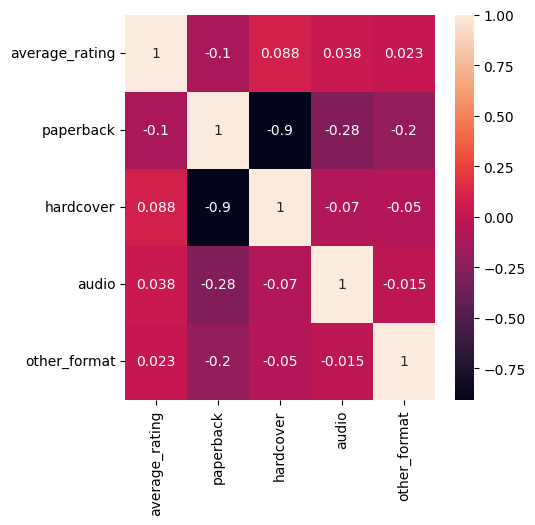

In [62]:
#Calculating the correlation matrix for book formats
plt.figure(figsize=(5,5))
sns.heatmap(dfGRcleaned.loc[:,["average_rating", "paperback", "hardcover", "audio", "other_format"]].corr(), annot=True)

<Axes: >

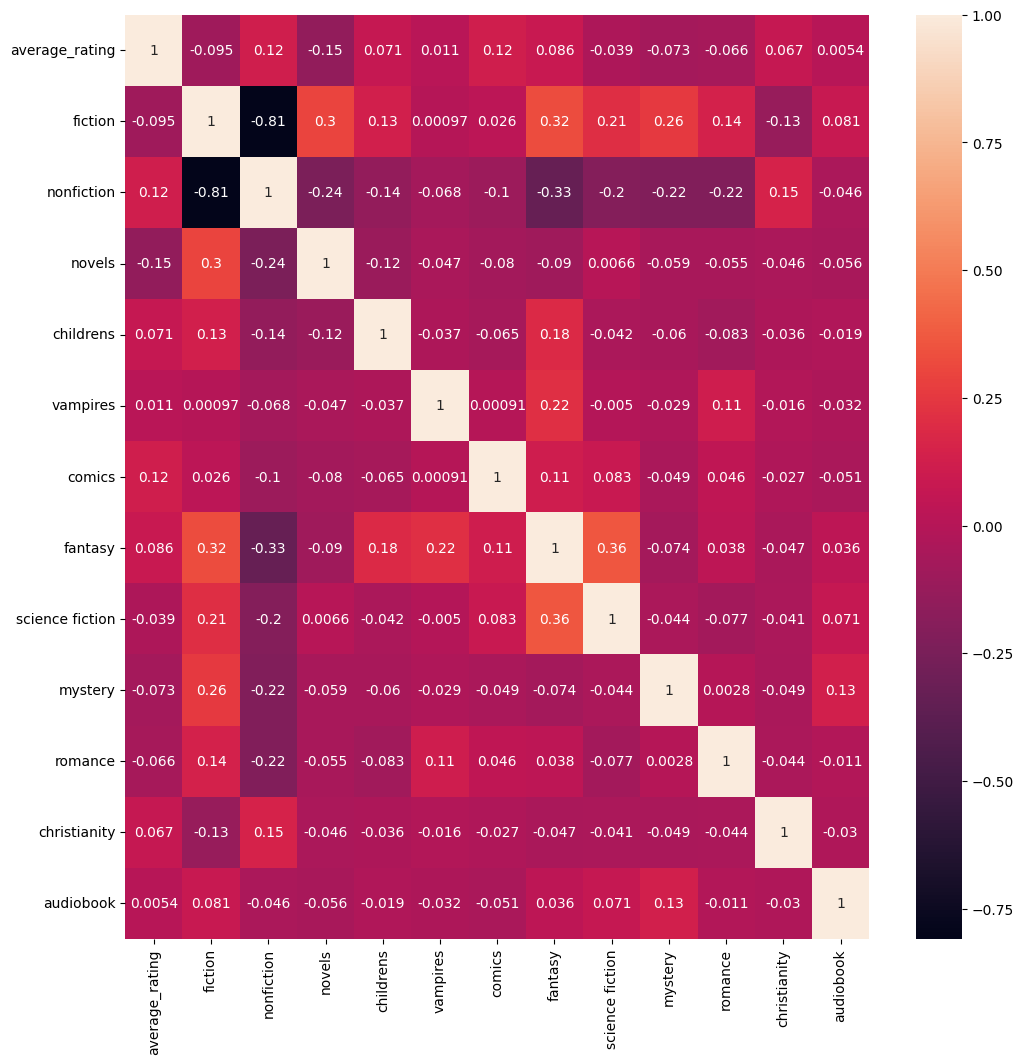

In [63]:
#Calculating the correlation matrix for genres
plt.figure(figsize=(12,12))
sns.heatmap(dfGRcleaned.loc[:,["average_rating", "fiction", "nonfiction", "novels", "childrens", "vampires", "comics", "fantasy", "science fiction", "mystery", "romance", "christianity", "audiobook"]].corr(), annot=True)

### **11) MODEL TESTING WITH SCRAPED DATA**

**11a) Create the train and test data sets**

In [64]:
#Recreate the same training and testing data sets as used in the previous modelization section
X_train = dfGRcleaned[dfGRcleaned["bookID"].isin(list_training_bookIDs)].copy() #includes all columns from dfGRcleaned
y_train = X_train["average_rating"].copy() #get the average rating from the X_train set
X_train.drop(labels=["bookID", "average_rating"], axis=1, inplace=True) #now remove the bookID and average rating from the X_train set

X_test = dfGRcleaned[dfGRcleaned["bookID"].isin(list_testing_bookIDs)].copy() #includes all columns from dfGRcleaned
y_test = X_test["average_rating"].copy() #get the average rating from the X_test set
X_test.drop(labels=["bookID", "average_rating"], axis=1, inplace=True) #now remove the bookID and average rating from the X_test set

**11b) Make a list of all genres and a list of sub-genres to facilitate modeling features selection**

In [65]:
#Make a list of all genres present in the final dataframe to model
list_all_genres = df_genres_vectorized.drop("bookID", axis=1, inplace=False).columns.to_list()
#Make a list of all subgenres present in the final dataframe to model (without "fiction" and "nonfiction")
list_sub_genres = list_all_genres
list_sub_genres.remove('fiction')
list_sub_genres.remove('nonfiction')

**11c) Use the polynomial regression model**

In [66]:
#The model is structured in the following way:
# -consider that every column in the dataframe will be tested in the model (the base feature set)
# -analyze variants by removing features from the base feature set
# -check the statistical results for each feature set
# -run the final feature set
# -run the permutations of the final feature set (cases where the author and/or publisher are new)
# -rerun the final feature set to have results available for analysis (note that every run is slightly different)

#First store the features to remove in the final model (this was added after checking which variants performed best)
final_features_list = ["ratings_count", "books_by_publisher", "language_code", "year", "month", "ratings_count_log"]+  list_sub_genres

#Make a dictionary of features to remove from complete list where:
#Key = name of feature set (will be in the printout)
#Value = list of features to remove from base dataset
testing_features_to_remove = {
    "ALL FEATURES": "",
    "NO SUBGENRES": list_sub_genres,
    "FINAL FEATURES": final_features_list,
    "NEW AUTHOR": ["avg_author_rating"] + final_features_list,
    "NEW PUBLISHER": ["avg_publisher_rating"] +  final_features_list,
    "NEW AUTHOR & PUBLISHER": ["avg_author_rating", "avg_publisher_rating"] +  final_features_list,
    "RERUN FINAL FEATURES": final_features_list
}

#Evaluate the model for each feature set
print("## POLYNOMIAL REGRESSION RESULTS ##\n")
for key, value in testing_features_to_remove.items():
    #Get the column names of all the features in the base set
    listVariables_poly_regr = X_train.columns.values.tolist()

    #If the list of features to remove is NOT empty, then proceed towards their removal from the base set
    if value != "":
        cols_to_remove = value
        for colname in cols_to_remove:
            listVariables_poly_regr.remove(colname)
    
    #Crete an object with the polynomial function of the desired degree
    polytrans = PolynomialFeatures(degree = 2)
    
    #Generate the polynomial transform for the TRAINING set (using the selected variables)
    X_train_polynomial = polytrans.fit_transform(X_train[listVariables_poly_regr])
    
    #Generate the polynomial transform for the TEST set (using the selected variables)
    X_test_polynomial = polytrans.fit_transform(X_test[listVariables_poly_regr])
    
    #Make the linear regression object
    regr = linear_model.LinearRegression()
    #Train the model
    regr.fit(X_train_polynomial, y_train)
    #Make predictions
    y_predict = regr.predict(X_test_polynomial)
    
    #Calculate statistical results
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test, y_predict)
    R2_score = r2_score(y_test, y_predict) #R2 = coefficient of determination (perfect = 1, worst = 0)
    
    #Calculate the adjusted R2 score
    n = len(X_train[listVariables_poly_regr])
    p = len(X_train[listVariables_poly_regr].columns)
    adj_R2 = 1- ((1-R2_score) * (n-1)/(n-p-1))
    
    #Print statistical results for each feature set and list the features used
    print("---", key, "---", sep="")
    print("Mean squared error: %.3f" % MSE)
    print("Root mean squared error: %.3f" % RMSE)
    print("Mean absolute error: %.4f" % MAE)
    print("Coefficient of determination: %.3f" % R2_score)
    print("Adjusted R2-score: %.3f" % adj_R2)
    print()
    print("Minimum predicted score = %.2f" % y_predict.min(), sep="")
    print("Maximum predicted score = %.2f" % y_predict.max(), sep="")
    print()
    print("Features used:", listVariables_poly_regr)
    print()
#Print important information after the model runs
print("!!! THE OUTPUT OF <<", key, ">> IS THE ONLY OUTPUT ACCESSIBLE AFTER RUNNING THIS CODE !!!", sep="")
print()
print("NOTE:   The base model uses the avg_author_rating and the avg_publisher_rating features.\n",
        "\tThe same model cannot be used if the author and/or the publisher are new.\n",
        "\tThe avg_author_rating is removed if the author is new.\n",
        "\tThe avg_publisher_rating is removed if the publisher is new."
        )

## POLYNOMIAL REGRESSION RESULTS ##

---ALL FEATURES---
Mean squared error: 2910675799021226.000
Root mean squared error: 53950679.319
Mean absolute error: 5203373.4404
Coefficient of determination: -37443587539985512.000
Adjusted R2-score: -37880273435370328.000

Minimum predicted score = -777720068.59
Maximum predicted score = 1147271125.05

Features used: ['language_code', 'num_pages', 'ratings_count', 'books_by_main_author', 'books_by_publisher', 'length_title', 'nb_authors', 'avg_author_rating', 'avg_publisher_rating', 'year', 'month', 'ratings_count_log', 'audio', 'hardcover', 'other_format', 'paperback', 'fiction', 'nonfiction', 'classics', 'fantasy', 'literature', 'historical fiction', 'history', 'mystery', 'novels', 'romance', 'childrens', 'philosophy', 'science fiction', 'young adult', 'contemporary', 'historical', 'biography', 'thriller', 'humor', 'adventure', 'short stories', 'crime', 'audiobook', 'science fiction fantasy', 'horror', 'mystery thriller', 'literary fiction', 

**11d) Use the random forest model**

In [67]:
# Model Pipeline - add more steps if necessary
model = Pipeline(steps=[
('regressor', RandomForestRegressor())
])

In [68]:
#The model is structured in the following way:
# -consider that every column in the dataframe will be tested in the model (the base feature set)
# -analyze variants by removing features from the base feature set
# -check the statistical results for each feature set
# -run the final feature set
# -run the permutations of the final feature set (cases where the author and/or publisher are new)
# -rerun the final feature set to have results available for analysis (note that every run is slightly different)

#First store the features to remove in the final model (this was added after checking which variants performed best)
final_features_list = ["ratings_count", "books_by_publisher", "language_code", "year", "month", "ratings_count_log"]

#Make a dictionary of features to remove from complete list where:
#Key = name of feature set (will be in the printout)
#Value = list of features to remove from base dataset
testing_features_to_remove = {
    "ALL FEATURES": "",
    "NO SUBGENRES": list_sub_genres,
    "FINAL FEATURES": final_features_list,
    "NEW AUTHOR": ["avg_author_rating"] + final_features_list,
    "NEW PUBLISHER": ["avg_publisher_rating"] +  final_features_list,
    "NEW AUTHOR & PUBLISHER": ["avg_author_rating", "avg_publisher_rating"] +  final_features_list,
    "RERUN FINAL FEATURES": final_features_list
}

#Evaluate the model for each feature set
print("## RANDOM FOREST REGRESSION RESULTS ##\n")
for key, value in testing_features_to_remove.items():
    #Get the column names of all the features in the base set
    listVariables_random_forest = X_train.columns.values.tolist()

    #If the list of features to remove is NOT empty, then proceed towards their removal from the base set
    if value != "":
        cols_to_remove = value
        for colname in cols_to_remove:
            listVariables_random_forest.remove(colname)
    
    #Create the model
    model.fit(pd.DataFrame(X_train[listVariables_random_forest]), y_train)
    
    #Predicting and Evaluating the model
    y_predict = model.predict(X_test[listVariables_random_forest])
    
    #Calculate statistical results
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test, y_predict)
    R2_score = r2_score(y_test, y_predict) #R2 = coefficient of determination (perfect = 1, worst = 0)
    
    #Calculate the adjusted R2 score
    n = len(X_train[listVariables_random_forest])
    p = len(X_train[listVariables_random_forest].columns)
    adj_R2 = 1- ((1-R2_score) * (n-1)/(n-p-1))
    
    #Print statistical results for each feature set and list the features used
    print("---", key, "---", sep="")
    print("Mean squared error: %.3f" % MSE)
    print("Root mean squared error: %.3f" % RMSE)
    print("Mean absolute error: %.4f" % MAE)
    print("Coefficient of determination: %.3f" % R2_score)
    print("Adjusted R2-score: %.3f" % adj_R2)
    print()
    print("Minimum predicted score = %.2f" % y_predict.min(), sep="")
    print("Maximum predicted score = %.2f" % y_predict.max(), sep="")
    print()
    print("Features used:", listVariables_random_forest)
    print()
#Print important information after the model runs
print("!!! THE OUTPUT OF <<", key, ">> IS THE ONLY OUTPUT ACCESSIBLE AFTER RUNNING THIS CODE !!!", sep="")
print()
print("NOTE:   The base model uses the avg_author_rating and the avg_publisher_rating features.\n",
        "\tThe same model cannot be used if the author and/or the publisher are new.\n",
        "\tThe avg_author_rating is removed if the author is new.\n",
        "\tThe avg_publisher_rating is removed if the publisher is new."
        )

## RANDOM FOREST REGRESSION RESULTS ##

---ALL FEATURES---
Mean squared error: 0.018
Root mean squared error: 0.135
Mean absolute error: 0.0903
Coefficient of determination: 0.764
Adjusted R2-score: 0.761

Minimum predicted score = 2.70
Maximum predicted score = 4.74

Features used: ['language_code', 'num_pages', 'ratings_count', 'books_by_main_author', 'books_by_publisher', 'length_title', 'nb_authors', 'avg_author_rating', 'avg_publisher_rating', 'year', 'month', 'ratings_count_log', 'audio', 'hardcover', 'other_format', 'paperback', 'fiction', 'nonfiction', 'classics', 'fantasy', 'literature', 'historical fiction', 'history', 'mystery', 'novels', 'romance', 'childrens', 'philosophy', 'science fiction', 'young adult', 'contemporary', 'historical', 'biography', 'thriller', 'humor', 'adventure', 'short stories', 'crime', 'audiobook', 'science fiction fantasy', 'horror', 'mystery thriller', 'literary fiction', 'memoir', 'american', 'politics', 'suspense', 'reference', 'religion', 'comic

### **12) POST-MODELIZATION ANALYSIS**

**12a) Examine the Random Forest model (with scraped data) results by ratings groups**

<BarContainer object of 12 artists>

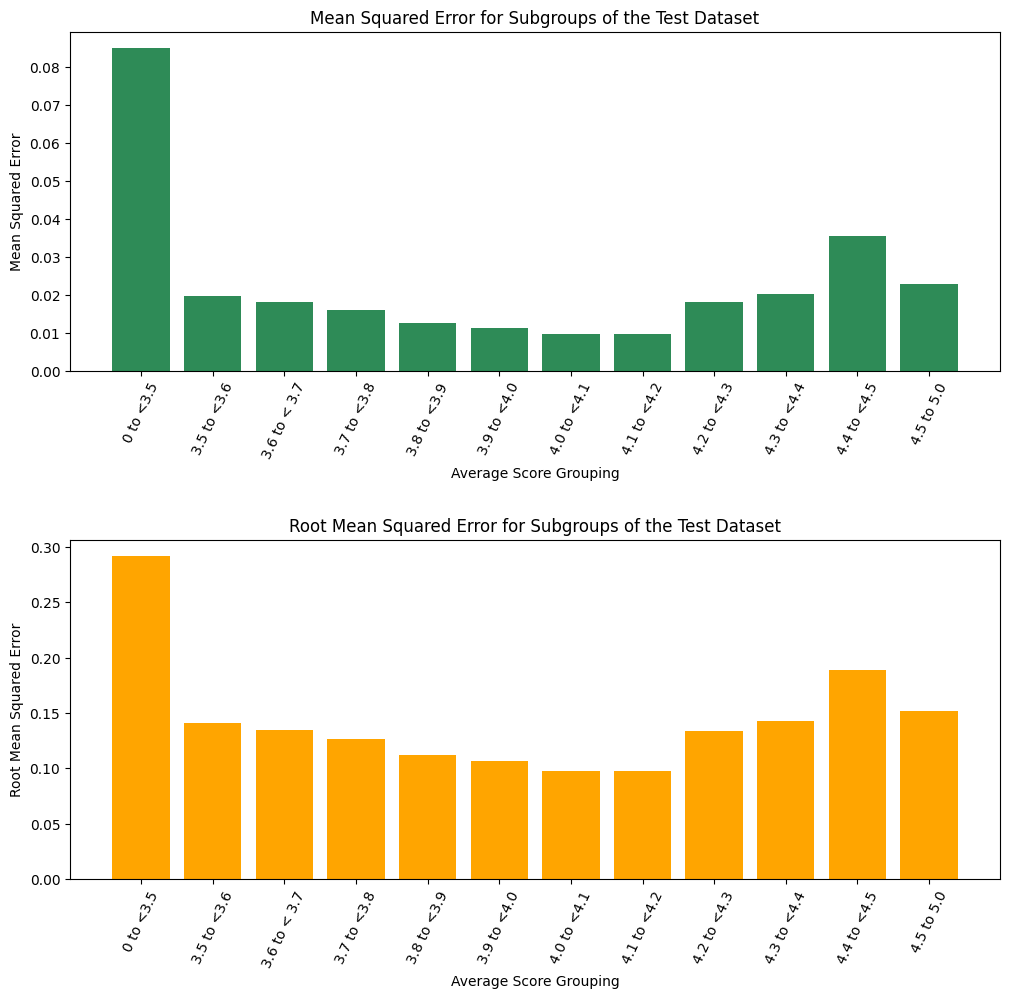

In [69]:
#Combine the test and predict target variable (average_rating) into a single dataframe and place the
#index number in a new column. This new dataframe will have new indices numbered sequentially from 0
#and the original indices must be recoreded for tracability.

#Convert each target array (predict and test) into a dataframe, knowing that only the y_test array has the indices from the original data
pred = pd.DataFrame(y_predict) #predicted average_rating stored in a dataframe
test_results = pd.DataFrame(y_test) #test average_rating stored in a dataframe
test_results = test_results.reset_index() #test df reindexed, with old index stored in a new column
test_results = pd.concat([test_results, pred], axis=1) #test and predict df are concatenated
test_results.columns = ["old_index","true_rating","predicted_rating"] #columns are renamed for clarity

#Function to calculate MSE and RMSE statistical results
#df = dataframe with test and predict target variables
#colnum_test = column number where the test target variables are stored
#colnum_predict = column number where the predict target variables are stored
#returns a tuple containing (MSE, RMSE)
def stat_results(df, colnum_test, colnum_predict):
    y_tested = df.iloc[:,colnum_test].values
    y_pred = df.iloc[:,colnum_predict].values
    MSE = mean_squared_error(y_tested, y_pred)
    RMSE = MSE**0.5
    return MSE, RMSE

#Split the combined test/predict dataframe into bins according to the values in the "true_rating" column
#Note that there is ONE FEWER entry in bin_labels than in bin_sequence since bin_sequence contains the two extremities
bin_sequence = [0, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 5.0]
bin_labels = ['0 to <3.5', '3.5 to <3.6', '3.6 to < 3.7', '3.7 to <3.8', '3.8 to <3.9', '3.9 to <4.0', '4.0 to <4.1',
              '4.1 to <4.2', '4.2 to <4.3', '4.3 to <4.4', '4.4 to <4.5', '4.5 to 5.0']
number_of_bins = len(bin_sequence) - 1

#Create empty lists of MSE and RMSE to update with results for each bin
MSE_results = [] 
RMSE_results = []

#Loop through the bins, adjusting the lower and upper bounds to use as criteria for selecting the rows to use in the dataframe
for i in range(number_of_bins):
    lower_bound = bin_sequence[i]
    upper_bound = bin_sequence[i + 1]
    df_temp = test_results[(test_results["true_rating"]>=lower_bound) & (test_results["true_rating"]<upper_bound)] #df where bounds are applied
    stats_i = stat_results(df_temp, 1, 2) #run the statistical function which returns a tuple of (MSE, RMSE)
    #Update the MSE and RMSE lists sequentially
    MSE_results.append(stats_i[0].item())
    RMSE_results.append(stats_i[1].item())

#Plot the statistical results of the binned test data
plt.figure(figsize=(12, 11))
plt.subplots_adjust(hspace=0.5)

#Subplot 1:  Mean Squared Error of the test set
ax = plt.subplot(2, 1, 1) #position 1
#ax.set_ylim([0, 0.12]) #set the y axis bounds if desired
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Average Score Grouping')
ax.set_title('Mean Squared Error for Subgroups of the Test Dataset')
plt.xticks(rotation=65)
plt.bar(bin_labels, MSE_results, color='seagreen')

#Subplot 2: Root Mean Squared Error of the test set
ax = plt.subplot(2, 1, 2) #position 2
#ax.set_ylim([0, 0.35]) #set the y axis bounds if desired
ax.set_ylabel('Root Mean Squared Error')
ax.set_xlabel('Average Score Grouping')
ax.set_title('Root Mean Squared Error for Subgroups of the Test Dataset')
plt.xticks(rotation=65)
plt.bar(bin_labels, RMSE_results, color='orange')

**OBSERVATION: The model is not excellent for ratings below 3.5, probably because there are few samples of this ranking, which makes it harder to predict. The model can predict particularly well between 3.6 to 4.4 since the RMSE is below 0.02.**

**12b) Examine the residuals**

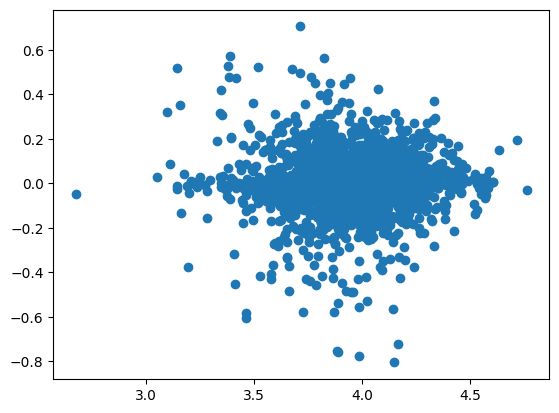

In [70]:
#Make a dataframe of test and predict ratings with the residuals
dict = {"test_rating": y_test, "predicted_rating": y_predict, "residual": y_test-y_predict}
df_residuals = pd.DataFrame(dict)

#Plot residuals
plt.scatter(y_predict, df_residuals["residual"])
plt.show()

In [71]:
#Associate the bookID to the residuals to facilitate analysis
df_residuals = df_residuals.merge(dfGRcleaned["bookID"], how="inner", left_index=True, right_index=True)
df_residuals

test_rating  predicted_rating  residual  bookID
21            3.91            3.9472   -0.0372   34303
23            3.92            3.6835    0.2365   35148
31            3.82            3.7203    0.0997   44758
40            4.02            4.2009   -0.1809   23925
42            3.99            4.0041   -0.0141    9031
...            ...               ...       ...     ...
10618         3.91            4.0468   -0.1368   33030
10620         4.28            4.3037   -0.0237   17364
10624         4.07            4.1611   -0.0911   19193
10625         3.57            3.7426   -0.1726   20423
10626         4.61            4.6061    0.0039     313

[2126 rows x 4 columns]

**12c) Take a closer look at books with excellent and terrible residuals**

In [72]:
#Find the lines where books are rating overly low (high residual)
df_residuals["abs_residual"] = abs(df_residuals["residual"])
low_residual = df_residuals[df_residuals["residual"]==df_residuals["residual"].min()]
high_residual = df_residuals[df_residuals["residual"]==df_residuals["residual"].max()]
bad_residuals = high_residual.merge(low_residual, how='outer')
print("BAD RESIDUALS:")
display(bad_residuals)
good_residuals = df_residuals.nsmallest(n=15,columns=["abs_residual"])
print("\nGOOD RESIDUALS:")
display(good_residuals)

BAD RESIDUALS:


test_rating  predicted_rating  residual  bookID  abs_residual
0         3.34            4.1452   -0.8052   18880        0.8052
1         4.42            3.7148    0.7052    4723        0.7052


GOOD RESIDUALS:


test_rating  predicted_rating  residual  bookID  abs_residual
6073         3.92            3.9199    0.0001   29597        0.0001
9471         3.82            3.8201   -0.0001    5055        0.0001
6810         3.43            3.4298    0.0002   41864        0.0002
6064         4.15            4.1502   -0.0002   31573        0.0002
4371         4.23            4.2303   -0.0003    4339        0.0003
7062         3.60            3.6003   -0.0003   23837        0.0003
3750         3.35            3.3503   -0.0003   28162        0.0003
6755         4.12            4.1195    0.0005   22126        0.0005
1308         3.97            3.9695    0.0005    3698        0.0005
5452         3.98            3.9805   -0.0005     565        0.0005
2812         3.68            3.6805   -0.0005   19619        0.0005
2453         4.59            4.5894    0.0006   26422        0.0006
5028         4.03            4.0306   -0.0006   32572        0.0006
7858         4.27            4.2706   -0.0006   41918        0.0006
6635         3.84            3.8406   -0.0006   31486        0.0006

In [73]:
#Look at the details of the bad predictions
residuals_to_examine = list(bad_residuals["bookID"].values)
df_residuals_data = dfGRcleaned_copy[dfGRcleaned_copy["bookID"].isin(residuals_to_examine)]
df_residuals_data = df_residuals_data.merge(dfScrapedData[dfScrapedData["bookID"].isin(residuals_to_examine)], left_on="bookID", right_on="bookID")
print("\nBAD RESIDUALS:")
df_residuals_data


BAD RESIDUALS:


bookID                                title  \
0    4723                           trimalchio   
1   18880  the younger gods (the dreamers  #4)   

                                   authors  average_rating        isbn  \
0  f. scott fitzgerald/james l.w. west iii            4.42  0521890470   
1              david eddings/leigh eddings            3.34  0446613320   

          isbn13  language_code  num_pages  ratings_count  text_reviews_count  \
0  9780521890472              0        214             41                   4   
1  9780446613323              0        420           4541                  85   

  publication_date      publisher         first_author  books_by_main_author  \
0       2002-04-25      cambridge  f. scott fitzgerald                    15   
1       2007-03-01  grand central        david eddings                     8   

   books_by_publisher  length_title  nb_authors  avg_author_rating  \
0                  62            10           2           3.938667   
1                  79            35           2           4.137500   

   avg_publisher_rating  year  month  quarter  z_scores_num_pages  audio  \
0              3.954194  2002      4        2           -0.525425  False   
1              3.917468  2007      3        1            0.333972  False   

   hardcover  other_format  paperback  fiction  nonfiction  classics  fantasy  \
0      False         False       True     True       False      True    False   
1      False         False       True     True       False     False     True   

   literature  historical fiction  history  mystery  novels  romance  \
0        True               False    False    False    True    False   
1       False               False    False    False   False    False   

   childrens  philosophy  science fiction  young adult  contemporary  \
0      False       False            False        False         False   
1      False       False            False        False         False   

   historical  biography  thriller  humor  adventure  short stories  crime  \
0       False      False     False  False      False          False  False   
1       False      False     False  False      False          False  False   

   audiobook  science fiction fantasy  horror  mystery thriller  \
0      False                    False   False             False   
1      False                     True   False             False   

   literary fiction  memoir  american  politics  suspense  reference  \
0             False   False      True     False     False      False   
1             False   False     False     False     False      False   

   religion  comics  poetry  graphic novels  middle grade  school  science  \
0     False   False   False           False         False   False    False   
1     False   False   False           False         False   False    False   

   psychology  british literature  adult  essays  chick lit    war  \
0       False               False  False   False      False  False   
1       False               False   True   False      False  False   

   paranormal  drama  self help  plays  france  picture books  manga  \
0       False  False      False  False   False          False  False   
1       False  False      False  False   False          False  False   

   biography memoir    art  spirituality  20th century  magic  comedy  travel  \
0             False  False         False          True  False   False   False   
1             False  False         False         False   True   False   False   

   high fantasy  anthologies  animals  mythology  business  detective  \
0         False        False    False      False     False      False   
1          True        False    False      False     False      False   

   christian  19th century  adult fiction  american history  autobiography  \
0      False         False          False             False          False   
1      False         False          False             False          False   

   theatre

In [74]:
#Look at the details of the good predictions
residuals_to_examine = list(good_residuals["bookID"].values)
df_residuals_data = dfGRcleaned_copy[dfGRcleaned_copy["bookID"].isin(residuals_to_examine)]
df_residuals_data = df_residuals_data.merge(dfScrapedData[dfScrapedData["bookID"].isin(residuals_to_examine)], left_on="bookID", right_on="bookID")
print("\nGOOD RESIDUALS:")
df_residuals_data


GOOD RESIDUALS:


bookID                                              title  \
0      565  the zen of css design: visual enlightenment fo...   
1     3698                                 the quiet american   
2     4339                                         dispatches   
3     5055                                   night over water   
4    19619  what life was like amid splendor and intrigue:...   
5    22126  betrayal of trust: the collapse of global publ...   
6    23837          healing therapies for overcoming insomnia   
7    26422  fullmetal alchemist  vol. 14 (fullmetal alchem...   
8    28162    bound in blood: the erotic journey of a vampire   
9    29597  through painted deserts: light  god  and beaut...   
10   31486             ruby the red fairy (rainbow magic  #1)   
11   31573                          50 great curries of india   
12   32572                the metamorphosis and other stories   
13   41864  american genesis: captain john smith and the f...   
14   41918  there are no children here: the story of two b...   

                                authors  average_rating        isbn  \
0         dave shea/molly e. holzschlag            3.98  0321303474   
1           graham greene/robert  stone            3.97  0143039024   
2                          michael herr            4.23  0679735259   
3                           ken follett            3.82  0451211472   
4             ellen anker/denise dersin            3.68  0783554575   
5     laurie garrett/steven m. wolinsky            4.12  0786884401   
6         peter  van houten/rich mccord            3.60  1565891740   
7         hiromu arakawa/akira watanabe            4.59  142151379X   
8                     david thomas lord            3.35  1575667649   
9                         donald miller            3.92  0785209824   
10         daisy meadows/georgie ripper            3.84  043973861X   
11                     camellia panjabi            4.15  1904920357   
12  franz kafka/donna freed/jason baker            4.03  1593081804   
13                     alden t. vaughan            3.43  0673393550   
14                       alex kotlowitz            4.27  0385265565   

           isbn13  language_code  num_pages  ratings_count  \
0   0785342303476              1        296            793   
1   9780143039020              0        180          37620   
2   9780679735250              0        260          13108   
3   9780451211477              0        448          14545   
4   9780783554570              0        144             49   
5   9780786884407              0        768           1126   
6   0798499100096              0        175              8   
7   9781421513799              0        192           8634   
8   9781575667645              1        352             71   
9   9780785209829              0        256           8931   
10  9780439738613              1         65           4334   
11  9781904920359              0        224            209   
12  9781593081805              0        191            132   
13  9780673393555              0        224             23   
14  9780385265560              0        323          12092   

    text_reviews_count publication_date          publisher       first_author  \
0                   28       2005-02-17           peachpit          dave shea   
1                 2298       2004-08-31    penguin  deluxe      graham greene   
2                  795       1991-08-06            vintage       michael herr   
3                  652       2004-04-06                nal        ken follett   
4                    2       1999-05-24  time life medical        ellen anker   
5                   50       2001-08-15           hachette     laurie garrett   
6                    1       2005-02-23    crystal clarity  peter  van houten   
7                  118       2007-08-14                viz     hiromu arakawa   
8                   10       2001-05-01         kensington  david thomas lord   
9                  444 

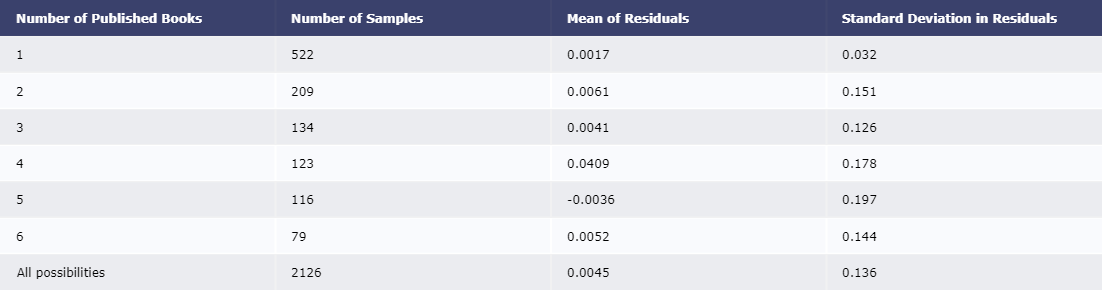

In [75]:
#Examine the statistical results according to the number of books published by the author
def stat_results_number_of_books(nb: int, df_data, df_residuals):
    #Get book ids corresponding to the desired number of books
    book_ids = list(df_data[df_data["books_by_main_author"]==nb]["bookID"].values)
    
    #Find the relevant residuals in the prediction results
    df_book_ids = df_residuals.loc[df_residuals["bookID"].isin(book_ids)]
    std = float('%.3f' % df_book_ids["residual"].std())
    mean = float('%.4f' % df_book_ids["residual"].mean())
    count_unique_books = df_book_ids["residual"].count()
    return [nb, count_unique_books, mean, std]

#Run the function, start a list containing the headers to be used in the table to be generated
nb_books_to_analyze = [1, 2, 3, 4, 5, 6]
res_std = [["Number of Published Books", "Number of Samples", "Mean of Residuals", "Standard Deviation in Residuals"]]
for nb_books in nb_books_to_analyze:
    res_std.append(stat_results_number_of_books(nb_books, dfGRcleaned_copy, df_residuals))

#Add the overall statistical data at the end of the list and make the table
import plotly.figure_factory as ff
general_res_std = ["All possibilities", df_residuals["residual"].count(), float('%.4f' % df_residuals["residual"].mean()), float('%.3f' % df_residuals["residual"].std())]
res_std.append(general_res_std)

fig = ff.create_table(res_std)
fig.show()

**OBSERVATION: When a book is the only publication by that author, the predictions are excellent, with the mean residual and standard deviation of residuals very close to zero. This is probably due to the rating of the book being already available in the the avg_author_rating feature... the average rating for 1 item is simply a copy of that item.**